# Setting Up

In [1]:
#pip install transformers

In [1]:
import pandas as pd
import numpy as np
import csv
import json
from pandas import json_normalize
import os
import sys
import re
import nltk
from nltk import word_tokenize, download
from nltk.corpus import stopwords
from tqdm import tqdm
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Model
from sklearn.utils import shuffle
import torch
import tensorflow as tf
import pickle

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Preparation (skip this if you have body_extracted.csv already)


In [3]:
dtype = {
    'body_text': 'object',
    'keywords': 'object',
}
# Change file path is needed
abstracts = pd.read_csv('data/open_access_journal.csv', dtype=dtype)

In [4]:
abstracts

Get the sentences out of the body_text

In [5]:
for index, row in tqdm(abstracts.iterrows()):
    data = row['body_text']
    data = ast.literal_eval(data)
    offset = np.array([item['startOffset'] for item in data])
    indexs = offset.argsort()
    sentences = [data[index]['sentence'] for index in indexs]
    paragraph = " ".join(sentences)
    abstracts.loc[index, 'body_text'] = paragraph

# abstracts.loc[0, 'body_text']

Save the body_extracted version (prevent from running the above code again)

In [6]:
# # Change file path is needed
# abstracts.to_csv('data/body_extracted.csv')

# Data Processing

In [7]:
# Change file path is needed
data = pd.read_csv('data/body_extracted.csv', index_col=0)
data

,docId,abstract,body_text,keywords,doi,subjareas
0,S0001457513002972,Objective The overall research objective was t...,Organizations often adopt safety management sy...,"['Accident prevention', 'Accident rates', 'Hum...",10.1016/j.aap.2013.07.029,"['ENGI', 'MEDI', 'SOCI']"
1,S0001457513004806,The objective of an accident-mapping algorithm...,"In 2012 Great Britain saw 1754 deaths, 23,039 ...","['Accident-mapping', 'Artificial neural networ...",10.1016/j.aap.2013.12.001,"['ENGI', 'MEDI', 'SOCI']"
2,S0001457514003091,The Driver Behavior Questionnaire (DBQ) is a s...,Road traffic crashes continue to present a ser...,"['Bifactor', 'Confirmatory factor analysis', '...",10.1016/j.aap.2014.10.012,"['ENGI', 'MEDI', 'SOCI']"
3,S0001457515001098,Operating a motor vehicle under the influence ...,Operating motor vehicles under the influence o...,"['Alcohol abuse', 'Impaired driving', 'Interve...",10.1016/j.aap.2015.03.027,"['ENGI', 'MEDI', 'SOCI']"
4,S000145751500127X,Driver drowsiness has been implicated as a maj...,Driver fatigue is a major causal factor in roa...,"['Alertness', 'Circadian phase', 'Driver fatig...",10.1016/j.aap.2015.03.041,"['ENGI', 'MEDI', 'SOCI']"
...,...,...,...,...,...,...
35365,S8756328219302856,Objective: Bone loss in anorexia nervosa and f...,"Bone loss, and increased fracture risk, are fe...","['Bone mineral density', 'Fracture', 'Osteobla...",10.1016/j.bone.2019.07.011,"['BIOC', 'MEDI']"
35366,S8756328219304004,There is an unmet need for a high-resolution t...,Bone is a dynamic tissue which is continually ...,"['3D imaging', 'Bone', 'High resolution', 'Ost...",10.1016/j.bone.2019.115107,"['BIOC', 'MEDI']"
35367,S8756328219304715,To explore the role of low expression of Pitx1...,Knee OA (osteoarthritis) is the most common fo...,"['Osteoarthritis', 'Pitx1', 'Senescence', 'Sir...",10.1016/j.bone.2019.115177,"['BIOC', 'MEDI']"
35368,S8756328219304739,Objective: To examine the relationship between...,Puberty is a period of rapid growth and is tho...,"['ALSPAC', 'Joint shape', 'Proximal femur shap...",10.1016/j.bone.2019.115179,"['BIOC', 'MEDI']"


Extract journals' name

In [8]:
def extract_journal(doi):
    # just get text after 'j.' until another '.'
    match = re.search(r'j\.([^\.]+)', doi)
    if match:
        name = match.group(1)
        return name

In [9]:
data['doi'] = data['doi'].apply(extract_journal)
data

,docId,abstract,body_text,keywords,doi,subjareas
0,S0001457513002972,Objective The overall research objective was t...,Organizations often adopt safety management sy...,"['Accident prevention', 'Accident rates', 'Hum...",aap,"['ENGI', 'MEDI', 'SOCI']"
1,S0001457513004806,The objective of an accident-mapping algorithm...,"In 2012 Great Britain saw 1754 deaths, 23,039 ...","['Accident-mapping', 'Artificial neural networ...",aap,"['ENGI', 'MEDI', 'SOCI']"
2,S0001457514003091,The Driver Behavior Questionnaire (DBQ) is a s...,Road traffic crashes continue to present a ser...,"['Bifactor', 'Confirmatory factor analysis', '...",aap,"['ENGI', 'MEDI', 'SOCI']"
3,S0001457515001098,Operating a motor vehicle under the influence ...,Operating motor vehicles under the influence o...,"['Alcohol abuse', 'Impaired driving', 'Interve...",aap,"['ENGI', 'MEDI', 'SOCI']"
4,S000145751500127X,Driver drowsiness has been implicated as a maj...,Driver fatigue is a major causal factor in roa...,"['Alertness', 'Circadian phase', 'Driver fatig...",aap,"['ENGI', 'MEDI', 'SOCI']"
...,...,...,...,...,...,...
35365,S8756328219302856,Objective: Bone loss in anorexia nervosa and f...,"Bone loss, and increased fracture risk, are fe...","['Bone mineral density', 'Fracture', 'Osteobla...",bone,"['BIOC', 'MEDI']"
35366,S8756328219304004,There is an unmet need for a high-resolution t...,Bone is a dynamic tissue which is continually ...,"['3D imaging', 'Bone', 'High resolution', 'Ost...",bone,"['BIOC', 'MEDI']"
35367,S8756328219304715,To explore the role of low expression of Pitx1...,Knee OA (osteoarthritis) is the most common fo...,"['Osteoarthritis', 'Pitx1', 'Senescence', 'Sir...",bone,"['BIOC', 'MEDI']"
35368,S8756328219304739,Objective: To examine the relationship between...,Puberty is a period of rapid growth and is tho...,"['ALSPAC', 'Joint shape', 'Proximal femur shap...",bone,"['BIOC', 'MEDI']"


We remove any journals that contains less than 22 documents because 22 is the average number of document in each journal; total_documents/total_journals. This will remove the less frequent journals and focus on statistically significant journals.

In [10]:
threshold = 22/len(data) # the remaining journals need to at least contain 22 articles
counts = data['doi'].value_counts(normalize=True)
data = data.loc[data['doi'].isin(counts[counts > threshold].index), :]
data

,docId,abstract,body_text,keywords,doi,subjareas
0,S0001457513002972,Objective The overall research objective was t...,Organizations often adopt safety management sy...,"['Accident prevention', 'Accident rates', 'Hum...",aap,"['ENGI', 'MEDI', 'SOCI']"
1,S0001457513004806,The objective of an accident-mapping algorithm...,"In 2012 Great Britain saw 1754 deaths, 23,039 ...","['Accident-mapping', 'Artificial neural networ...",aap,"['ENGI', 'MEDI', 'SOCI']"
2,S0001457514003091,The Driver Behavior Questionnaire (DBQ) is a s...,Road traffic crashes continue to present a ser...,"['Bifactor', 'Confirmatory factor analysis', '...",aap,"['ENGI', 'MEDI', 'SOCI']"
3,S0001457515001098,Operating a motor vehicle under the influence ...,Operating motor vehicles under the influence o...,"['Alcohol abuse', 'Impaired driving', 'Interve...",aap,"['ENGI', 'MEDI', 'SOCI']"
4,S000145751500127X,Driver drowsiness has been implicated as a maj...,Driver fatigue is a major causal factor in roa...,"['Alertness', 'Circadian phase', 'Driver fatig...",aap,"['ENGI', 'MEDI', 'SOCI']"
...,...,...,...,...,...,...
35365,S8756328219302856,Objective: Bone loss in anorexia nervosa and f...,"Bone loss, and increased fracture risk, are fe...","['Bone mineral density', 'Fracture', 'Osteobla...",bone,"['BIOC', 'MEDI']"
35366,S8756328219304004,There is an unmet need for a high-resolution t...,Bone is a dynamic tissue which is continually ...,"['3D imaging', 'Bone', 'High resolution', 'Ost...",bone,"['BIOC', 'MEDI']"
35367,S8756328219304715,To explore the role of low expression of Pitx1...,Knee OA (osteoarthritis) is the most common fo...,"['Osteoarthritis', 'Pitx1', 'Senescence', 'Sir...",bone,"['BIOC', 'MEDI']"
35368,S8756328219304739,Objective: To examine the relationship between...,Puberty is a period of rapid growth and is tho...,"['ALSPAC', 'Joint shape', 'Proximal femur shap...",bone,"['BIOC', 'MEDI']"


List of all the unique journals

In [11]:
unique_dois = data['doi'].unique()
dois_list = unique_dois.tolist()
print("Number of journals: " + str(len(dois_list)))
print(dois_list)

Number of journals: 378
['aap', 'actatropica', 'ajhg', 'aca', 'anbehav', 'apergo', 'brat', 'bbrc', 'bcp', 'biocon', 'biopsych', 'brainres', 'carres', 'ces', 'chemgeo', 'cognition', 'combustflame', 'corsci', 'cortex', 'ydbio', 'epsl', 'earscirev', 'electacta', 'envres', 'ejphar', 'eurpolymj', 'exer', 'expneurol', 'fuel', 'futures', 'ygcen', 'gca', 'geoderma', 'geoforum', 'icarus', 'ijpara', 'atherosclerosis', 'jbiomech', 'chroma', 'jcis', 'jcrysgro', 'jecp', 'jhydrol', 'jim', 'yjmcc', 'jmb', 'jnucmat', 'xphs', 'jpsychores', 'jsv', 'jss', 'lithos', 'margeo', 'marpolbul', 'neuropharm', 'neuropsychologia', 'oceaneng', 'palaeo', 'physbeh', 'pss', 'polymer', 'powtec', 'rse', 'soilbio', 'solener', 'susc', 'talanta', 'techfore', 'tecto', 'tet', 'tsf', 'taap', 'virol', 'visres', 'watres', 'aquaculture', 'chemosphere', 'respol', 'scitotenv', 'pocean', 'jaci', 'ypmed', 'cell', 'eneco', 'engstruct', 'biomaterials', 'aquaeng', 'carbpol', 'chiabu', 'dci', 'jbusres', 'neubiorev', 'intell', 'envint', 

List of all the unique subject areas

In [12]:
subjarea_lists = data['subjareas'].apply(eval)
flat_subject_areas = [subj for subj_list in subjarea_lists for subj in subj_list]
unique_subject_areas = list(set(flat_subject_areas))
print("Number of unique subject areas: " + str(len(unique_subject_areas)))
print(unique_subject_areas)

Number of unique subject areas: 26
['ENVI', 'MATH', 'MEDI', 'MATE', 'HEAL', 'DECI', 'SOCI', 'ENER', 'PSYC', 'BUSI', 'CENG', 'VETE', 'ARTS', 'BIOC', 'IMMU', 'AGRI', 'ECON', 'PHAR', 'NURS', 'COMP', 'ENGI', 'PHYS', 'MULT', 'EART', 'CHEM', 'NEUR']


In [13]:
def to_lower(X):
    X = X.str.lower()
    return X

In [14]:
def clean_text(X):
    X = X.str.replace(r'[^a-z\s]+', '', regex=True)
    return X

Grab articles by the subject area

In [15]:
def get_data(subject_area):
    bools = [subject_area in row for row in data['subjareas']]
    df = data.loc[bools, :]
    return df

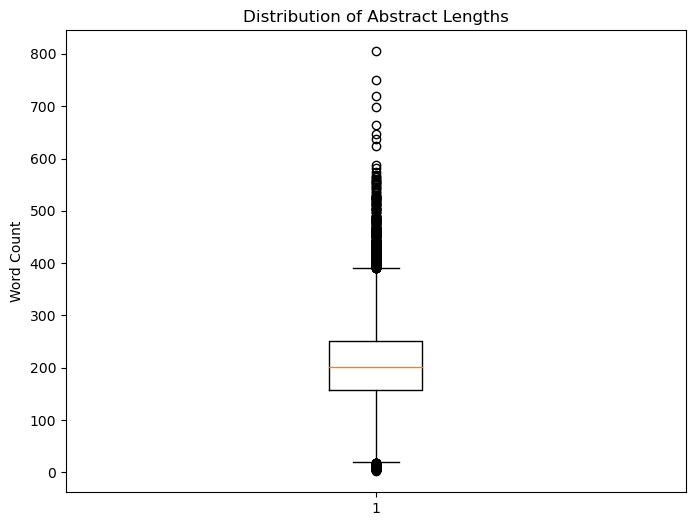

In [16]:
abs = data.abstract
lengths = abs.str.split().apply(len)
plt.figure(figsize=(8, 6))
plt.boxplot(lengths)
plt.title('Distribution of Abstract Lengths')
plt.ylabel('Word Count')
plt.show()

# Abstract model (with SciBERT)

In [18]:
sciBert_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

Y = data.doi
le = LabelEncoder()
le.fit(Y)
NUM_CLASSES = len(le.classes_)

In [43]:
def one_hot_encoding(y, journal_no):
    encoded = np.zeros((len(y), journal_no))
    for i, each in enumerate(y):
        encoded[i][each] = 1
    return encoded

def get_embeddings(sentences, batch_size=50, max_length=500):
    with torch.no_grad():
        embeddings = []  # Initialize a list to accumulate embeddings
        for idx in tqdm(range(0, len(sentences), batch_size)):
            batched_sentences = sentences[idx : min(len(sentences), idx + batch_size)]
            encoded = tokenizer(batched_sentences, truncation=True, return_tensors='pt', padding="max_length", max_length=max_length)
            batch_embeddings = sciBert_model(**encoded).last_hidden_state[:, 0].cpu().numpy()
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

def train_data_scibert(df):
    X = df.abstract
    y = df.doi
    
    # One-hot encode y
    y = le.transform(y)
    count_unique = len(np.unique(y))    
    y = one_hot_encoding(y, NUM_CLASSES)
    print(f"Number of unique journals: {count_unique}", )

    X = clean_text(to_lower(X))
    embeddings = list(get_embeddings(list(X)))
    
    TEST_SIZE = 0.25
    X_train, X_test, y_train, y_test, embeddings_train, embeddings_test = train_test_split(X, y, embeddings, test_size=TEST_SIZE, random_state=100)
    
    return embeddings_train, embeddings_test, y_train, y_test, embeddings

def train_data(df):
    embeddings_train, embeddings_test, y_train, y_test, embeddings = train_data_scibert(df)
    input_layer = Input(shape=(768,))
    dense_layer = Dense(NUM_CLASSES, activation="softmax")(input_layer)
    model = Model(inputs=input_layer, outputs=dense_layer)
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Fit the model with embeddings
    model.fit(np.array(embeddings_train), np.array(y_train), 
              validation_data=(np.array(embeddings_test), np.array(y_test)), batch_size=32, epochs=100)
    return model, embeddings

## Jump to Load embeddings if you have embeddings already

In [142]:
subj_models_scibert = {} # {subj: model}
subj_embeddings = {} # {subj: embedding}

for subj in unique_subject_areas:
    print(f"\nLearning for subject: {subj}")
    df = get_data(subj)
    print(f"Number of documents: {len(df)}")
    model, embedding = train_data(df)
    subj_models_scibert[subj] = model
    subj_embeddings[subj] = embedding


Learning for subject: DECI
Number of documents: 245
Number of unique journals: 5


100%|██████████| 5/5 [04:02<00:00, 48.41s/it]

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_11 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


6/6 [==============================] - 1s 41ms/step - loss: 4.9008 - accuracy: 0.0601 - val_loss: 3.0512 - val_accuracy: 0.0968
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 2.2010 - accuracy: 0.2623 - val_loss: 1.4690 - val_accuracy: 0.4194
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 1.3091 - accuracy: 0.5137 - val_loss: 1.1580 - val_accuracy: 0.5484
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 1.1412 - accuracy: 0.5410 - val_loss: 1.0322 - val_accuracy: 0.6129
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.9978 - accuracy: 0.6066 - val_loss: 0.9312 - val_accuracy: 0.6935
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.8722 - accuracy: 0.6776 - val_loss: 0.8875 - val_accuracy: 0.6935
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 0.7938 - accuracy: 0.7650 - val_loss: 0.8135 - val_accuracy: 0.6935
Epoch 8/100
6/6 [===============

100%|██████████| 57/57 [46:58<00:00, 49.44s/it]


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_12 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
67/67 [==============================] - 1s 10ms/step - loss: 1.2140 - accuracy: 0.6800 - val_loss: 0.4338 - val_accuracy: 0.8458
Epoch 2/100
67/67 [==============================] - 1s 9ms/step - loss: 0.4352 - accuracy: 0.8277 - val_loss: 0.3713 - val_accuracy: 0.8713
Epoch 3/100
67/67 [==============================] - 1s 10ms/step - loss: 0.3741 - accuracy: 0.8664 - val_loss: 0.3414 - val_accuracy: 

100%|██████████| 32/32 [23:42<00:00, 44.46s/it]

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_13 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


38/38 [==============================] - 1s 13ms/step - loss: 3.5456 - accuracy: 0.1532 - val_loss: 2.7897 - val_accuracy: 0.2670
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 2.4276 - accuracy: 0.3561 - val_loss: 2.3959 - val_accuracy: 0.3652
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 2.0355 - accuracy: 0.4428 - val_loss: 2.1436 - val_accuracy: 0.3955
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 1.7889 - accuracy: 0.5194 - val_loss: 2.0090 - val_accuracy: 0.4081
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 1.6115 - accuracy: 0.5589 - val_loss: 1.9178 - val_accuracy: 0.4181
Epoch 6/100
38/38 [==============================] - 0s 10ms/step - loss: 1.4778 - accuracy: 0.5934 - val_loss: 1.8546 - val_accuracy: 0.4559
Epoch 7/100
38/38 [==============================] - 0s 9ms/step - loss: 1.3536 - accuracy: 0.6271 - val_loss: 1.7411 - val_accuracy: 0.4786
Epoch 8/100
38/38 [===

100%|██████████| 44/44 [33:20<00:00, 45.47s/it]

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_14 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
52/52 [==============================] - 1s 11ms/step - loss: 3.4220 - accuracy: 0.1960 - val_loss: 2.7358 - val_accuracy: 0.3144
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 2.3929 - accuracy: 0.3694 - val_loss: 2.3764 - val_accuracy: 0.3766
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 2.0376 - accuracy: 0.4597 - val_loss: 2.1834 - val_accuracy: 0.3967
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 1.7960 - accuracy: 0.5061 - val_loss: 2.0809 - val_accuracy: 0.4186
Epoch 5/100
52/52 [==============================] - 0s 7ms/step - loss: 1.6356 - accuracy: 0.5598 - val_loss: 2.0013 - val_accuracy: 0.4278
Epoch 6/100
52/52 [==============================] - 0s 7ms/step - loss: 1.5097 - accuracy: 0.5983 - val_loss: 1.9195 - val_accuracy: 0.4534
Epoch 7/100
52/52 [==============================] - 0s 7ms/step - loss: 1.3982 - accuracy: 0.6300 - val_loss: 1.9258 - val_accuracy: 0.4570
Epoch 8/100


100%|██████████| 11/11 [07:51<00:00, 42.85s/it]

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_15 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


12/12 [==============================] - 1s 26ms/step - loss: 3.5886 - accuracy: 0.1518 - val_loss: 2.0585 - val_accuracy: 0.3125
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 1.8789 - accuracy: 0.3377 - val_loss: 1.7368 - val_accuracy: 0.3984
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 1.5726 - accuracy: 0.4660 - val_loss: 1.5844 - val_accuracy: 0.4453
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 1.3745 - accuracy: 0.6021 - val_loss: 1.4592 - val_accuracy: 0.5078
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 1.2266 - accuracy: 0.6387 - val_loss: 1.3751 - val_accuracy: 0.5234
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 1.1197 - accuracy: 0.7042 - val_loss: 1.3343 - val_accuracy: 0.5312
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 1.0307 - accuracy: 0.7225 - val_loss: 1.2816 - val_accuracy: 0.5781
Epoch 8/100
12/12 

100%|██████████| 98/98 [1:13:43<00:00, 45.14s/it]


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_16 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
114/114 [==============================] - 2s 10ms/step - loss: 3.3637 - accuracy: 0.2122 - val_loss: 2.6175 - val_accuracy: 0.3278
Epoch 2/100
114/114 [==============================] - 1s 10ms/step - loss: 2.3061 - accuracy: 0.3775 - val_loss: 2.3105 - val_accuracy: 0.3715
Epoch 3/100
114/114 [==============================] - 1s 10ms/step - loss: 1.9614 - accuracy: 0.4492 - val_loss: 2.1208 - val_acc

Epoch 53/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2834 - accuracy: 0.9580 - val_loss: 2.1948 - val_accuracy: 0.4292
Epoch 54/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2794 - accuracy: 0.9583 - val_loss: 2.2171 - val_accuracy: 0.4465
Epoch 55/100
114/114 [==============================] - 1s 9ms/step - loss: 0.2728 - accuracy: 0.9635 - val_loss: 2.1903 - val_accuracy: 0.4448
Epoch 56/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2660 - accuracy: 0.9627 - val_loss: 2.2163 - val_accuracy: 0.4382
Epoch 57/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2609 - accuracy: 0.9616 - val_loss: 2.2399 - val_accuracy: 0.4432
Epoch 58/100
114/114 [==============================] - 1s 8ms/step - loss: 0.2565 - accuracy: 0.9632 - val_loss: 2.2257 - val_accuracy: 0.4432
Epoch 59/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2486 - accuracy: 0.9671 - val_loss: 2.2280 - val_accurac

100%|██████████| 70/70 [48:29<00:00, 41.56s/it]


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_17 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 1s 10ms/step - loss: 2.9343 - accuracy: 0.3326 - val_loss: 2.0728 - val_accuracy: 0.4769
Epoch 2/100
82/82 [==============================] - 1s 9ms/step - loss: 1.6646 - accuracy: 0.5688 - val_loss: 1.6469 - val_accuracy: 0.5727
Epoch 3/100
82/82 [==============================] - 1s 9ms/step - loss: 1.2832 - accuracy: 0.6755 - val_loss: 1.4824 - val_accuracy: 0

Epoch 54/100
82/82 [==============================] - 1s 10ms/step - loss: 0.0722 - accuracy: 0.9973 - val_loss: 1.2757 - val_accuracy: 0.6628
Epoch 55/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0678 - accuracy: 0.9977 - val_loss: 1.2574 - val_accuracy: 0.6767
Epoch 56/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0646 - accuracy: 0.9977 - val_loss: 1.2652 - val_accuracy: 0.6790
Epoch 57/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0621 - accuracy: 0.9977 - val_loss: 1.2653 - val_accuracy: 0.6744
Epoch 58/100
82/82 [==============================] - 1s 8ms/step - loss: 0.0603 - accuracy: 0.9981 - val_loss: 1.2786 - val_accuracy: 0.6709
Epoch 59/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0589 - accuracy: 0.9985 - val_loss: 1.2745 - val_accuracy: 0.6732
Epoch 60/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0559 - accuracy: 0.9992 - val_loss: 1.2894 - val_accuracy: 0.6744
Epoch

100%|██████████| 36/36 [27:49<00:00, 46.38s/it]

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_18 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
43/43 [==============================] - 1s 14ms/step - loss: 3.3296 - accuracy: 0.1871 - val_loss: 2.3529 - val_accuracy: 0.4143
Epoch 2/100
43/43 [==============================] - 0s 10ms/step - loss: 1.9850 - accuracy: 0.4573 - val_loss: 1.8905 - val_accuracy: 0.5167
Epoch 3/100
43/43 [==============================] - 0s 10ms/step - loss: 1.6006 - accuracy: 0.5501 - val_loss: 1.6754 - val_accuracy: 0.5657
Epoch 4/100
43/43 [==============================] - 0s 8ms/step - loss: 1.3709 - accuracy: 0.6102 - val_loss: 1.5626 - val_accuracy: 0.5434
Epoch 5/100
43/43 [==============================] - 0s 9ms/step - loss: 1.2204 - accuracy: 0.6719 - val_loss: 1.4966 - val_accuracy: 0.5657
Epoch 6/100
43/43 [==============================] - 0s 10ms/step - loss: 1.1173 - accuracy: 0.6882 - val_loss: 1.4561 - val_accuracy: 0.6058
Epoch 7/100
43/43 [==============================] - 0s 9ms/step - loss: 1.0147 - accuracy: 0.7305 - val_loss: 1.3843 - val_accuracy: 0.5835
Epoch 8/1

Epoch 59/100
43/43 [==============================] - 0s 10ms/step - loss: 0.1272 - accuracy: 0.9955 - val_loss: 1.5287 - val_accuracy: 0.5924
Epoch 60/100
43/43 [==============================] - 0s 11ms/step - loss: 0.1241 - accuracy: 0.9963 - val_loss: 1.5182 - val_accuracy: 0.5947
Epoch 61/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1212 - accuracy: 0.9933 - val_loss: 1.5335 - val_accuracy: 0.5880
Epoch 62/100
43/43 [==============================] - 0s 10ms/step - loss: 0.1168 - accuracy: 0.9978 - val_loss: 1.5408 - val_accuracy: 0.5857
Epoch 63/100
43/43 [==============================] - 0s 11ms/step - loss: 0.1149 - accuracy: 0.9978 - val_loss: 1.5443 - val_accuracy: 0.5835
Epoch 64/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1110 - accuracy: 0.9970 - val_loss: 1.5470 - val_accuracy: 0.5947
Epoch 65/100
43/43 [==============================] - 0s 10ms/step - loss: 0.1060 - accuracy: 0.9963 - val_loss: 1.5578 - val_accuracy: 0.5924
E

100%|██████████| 54/54 [41:40<00:00, 46.30s/it]

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_19 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


64/64 [==============================] - 1s 7ms/step - loss: 3.0582 - accuracy: 0.2253 - val_loss: 2.2648 - val_accuracy: 0.3719
Epoch 2/100
64/64 [==============================] - 0s 7ms/step - loss: 1.9965 - accuracy: 0.4249 - val_loss: 1.9194 - val_accuracy: 0.4741
Epoch 3/100
64/64 [==============================] - 1s 10ms/step - loss: 1.6663 - accuracy: 0.5222 - val_loss: 1.7719 - val_accuracy: 0.4830
Epoch 4/100
64/64 [==============================] - 1s 11ms/step - loss: 1.4682 - accuracy: 0.5736 - val_loss: 1.6695 - val_accuracy: 0.5230
Epoch 5/100
64/64 [==============================] - 1s 8ms/step - loss: 1.3444 - accuracy: 0.6215 - val_loss: 1.6128 - val_accuracy: 0.5422
Epoch 6/100
64/64 [==============================] - 1s 11ms/step - loss: 1.2424 - accuracy: 0.6433 - val_loss: 1.5866 - val_accuracy: 0.5289
Epoch 7/100
64/64 [==============================] - 1s 10ms/step - loss: 1.1497 - accuracy: 0.6774 - val_loss: 1.5427 - val_accuracy: 0.5437
Epoch 8/100
64/64 [==

100%|██████████| 19/19 [12:34<00:00, 39.71s/it]

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_20 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


23/23 [==============================] - 1s 15ms/step - loss: 3.1056 - accuracy: 0.2752 - val_loss: 1.7711 - val_accuracy: 0.4255
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 1.4268 - accuracy: 0.5674 - val_loss: 1.2325 - val_accuracy: 0.7021
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 1.0133 - accuracy: 0.7291 - val_loss: 1.0216 - val_accuracy: 0.7447
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 0.8312 - accuracy: 0.7830 - val_loss: 0.9046 - val_accuracy: 0.7702
Epoch 5/100
23/23 [==============================] - 0s 7ms/step - loss: 0.6968 - accuracy: 0.8142 - val_loss: 0.8267 - val_accuracy: 0.8170
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 0.6095 - accuracy: 0.8582 - val_loss: 0.7687 - val_accuracy: 0.8000
Epoch 7/100
23/23 [==============================] - 0s 12ms/step - loss: 0.5377 - accuracy: 0.8695 - val_loss: 0.7532 - val_accuracy: 0.7957
Epoch 8/100
23/23 [===

100%|██████████| 3/3 [01:19<00:00, 26.40s/it]

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_21 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


3/3 [==============================] - 0s 79ms/step - loss: 6.3177 - accuracy: 0.0000e+00 - val_loss: 4.8786 - val_accuracy: 0.0385
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 4.3591 - accuracy: 0.2763 - val_loss: 2.9956 - val_accuracy: 0.7308
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 2.5681 - accuracy: 0.7105 - val_loss: 1.5209 - val_accuracy: 0.7308
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 1.2667 - accuracy: 0.7763 - val_loss: 0.8140 - val_accuracy: 0.7308
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6658 - accuracy: 0.7895 - val_loss: 0.5531 - val_accuracy: 0.7308
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.4303 - accuracy: 0.8158 - val_loss: 0.4299 - val_accuracy: 0.7692
Epoch 7/100
3/3 [==============================] - 0s 18ms/step - loss: 0.3263 - accuracy: 0.8684 - val_loss: 0.3445 - val_accuracy: 0.8077
Epoch 8/100
3/3 [===========

100%|██████████| 83/83 [55:15<00:00, 39.95s/it]


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_22 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
97/97 [==============================] - 1s 9ms/step - loss: 2.8904 - accuracy: 0.3763 - val_loss: 2.0088 - val_accuracy: 0.5000
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 1.5714 - accuracy: 0.6030 - val_loss: 1.5574 - val_accuracy: 0.6019
Epoch 3/100
97/97 [==============================] - 1s 7ms/step - loss: 1.1675 - accuracy: 0.7147 - val_loss: 1.3394 - val_accuracy: 0.

Epoch 54/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0240 - accuracy: 0.9997 - val_loss: 1.0378 - val_accuracy: 0.7282
Epoch 55/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0236 - accuracy: 0.9994 - val_loss: 1.0580 - val_accuracy: 0.7301
Epoch 56/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0220 - accuracy: 1.0000 - val_loss: 1.0608 - val_accuracy: 0.7359
Epoch 57/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0211 - accuracy: 0.9994 - val_loss: 1.0688 - val_accuracy: 0.7320
Epoch 58/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 1.0630 - val_accuracy: 0.7272
Epoch 59/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 1.0674 - val_accuracy: 0.7311
Epoch 60/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 1.0729 - val_accuracy: 0.7262
Epo

100%|██████████| 48/48 [42:21<00:00, 52.95s/it]

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_24 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_23 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 2s 16ms/step - loss: 3.3636 - accuracy: 0.2037 - val_loss: 2.6100 - val_accuracy: 0.3187
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 2.2366 - accuracy: 0.4102 - val_loss: 2.2547 - val_accuracy: 0.3659
Epoch 3/100
56/56 [==============================] - 1s 15ms/step - loss: 1.8504 - accuracy: 0.5008 - val_loss: 2.0625 - val_accuracy: 0.4300
Epoch 4/100
56/56 [==============================] - 1s 17ms/step - loss: 1.6065 - accuracy: 0.5627 - val_loss: 1.9662 - val_accuracy: 0.4368


Epoch 55/100
56/56 [==============================] - 1s 14ms/step - loss: 0.1511 - accuracy: 0.9916 - val_loss: 1.8036 - val_accuracy: 0.5211
Epoch 56/100
56/56 [==============================] - 1s 17ms/step - loss: 0.1503 - accuracy: 0.9927 - val_loss: 1.7892 - val_accuracy: 0.5211
Epoch 57/100
56/56 [==============================] - 1s 19ms/step - loss: 0.1460 - accuracy: 0.9927 - val_loss: 1.8041 - val_accuracy: 0.5126
Epoch 58/100
56/56 [==============================] - 1s 15ms/step - loss: 0.1389 - accuracy: 0.9916 - val_loss: 1.8641 - val_accuracy: 0.5177
Epoch 59/100
56/56 [==============================] - 1s 16ms/step - loss: 0.1390 - accuracy: 0.9921 - val_loss: 1.8197 - val_accuracy: 0.5110
Epoch 60/100
56/56 [==============================] - 1s 18ms/step - loss: 0.1304 - accuracy: 0.9949 - val_loss: 1.8409 - val_accuracy: 0.5194
Epoch 61/100
56/56 [==============================] - 1s 19ms/step - loss: 0.1300 - accuracy: 0.9927 - val_loss: 1.8343 - val_accuracy: 0.5160

100%|██████████| 47/47 [43:27<00:00, 55.49s/it]

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_24 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


55/55 [==============================] - 1s 15ms/step - loss: 2.7609 - accuracy: 0.3550 - val_loss: 1.9005 - val_accuracy: 0.5138
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 1.5991 - accuracy: 0.5978 - val_loss: 1.5151 - val_accuracy: 0.5793
Epoch 3/100
55/55 [==============================] - 1s 18ms/step - loss: 1.2523 - accuracy: 0.6726 - val_loss: 1.3157 - val_accuracy: 0.6224
Epoch 4/100
55/55 [==============================] - 1s 17ms/step - loss: 1.0406 - accuracy: 0.7376 - val_loss: 1.1983 - val_accuracy: 0.6586
Epoch 5/100
55/55 [==============================] - 1s 13ms/step - loss: 0.9085 - accuracy: 0.7641 - val_loss: 1.1527 - val_accuracy: 0.6741
Epoch 6/100
55/55 [==============================] - 1s 12ms/step - loss: 0.8049 - accuracy: 0.7934 - val_loss: 1.0661 - val_accuracy: 0.6966
Epoch 7/100
55/55 [==============================] - 1s 17ms/step - loss: 0.7208 - accuracy: 0.8285 - val_loss: 1.0317 - val_accuracy: 0.7207
Epoch 8/100
55/55 

100%|██████████| 14/14 [13:05<00:00, 56.11s/it]

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_25 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
17/17 [==============================] - 1s 45ms/step - loss: 2.8285 - accuracy: 0.3558 - val_loss: 1.3863 - val_accuracy: 0.5287
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 1.1231 - accuracy: 0.6308 - val_loss: 0.9517 - val_accuracy: 0.6782
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 0.7925 - accuracy: 0.7500 - val_loss: 0.7808 - val_accuracy: 0.7011
Epoch 4/100
17/17 [==============================] - 0s 18ms/step - loss: 0.6378 - accuracy: 0.8173 - val_loss: 0.6989 - val_accuracy: 0.7184
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 0.5366 - accuracy: 0.8442 - val_loss: 0.6325 - val_accuracy: 0.7586
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 0.4759 - accuracy: 0.8635 - val_loss: 0.6035 - val_accuracy: 0.7644
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 0.4287 - accuracy: 0.8596 - val_loss: 0.5791 - val_accuracy: 0.7874
Epoch 

100%|██████████| 32/32 [29:57<00:00, 56.16s/it]

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_26 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


37/37 [==============================] - 2s 26ms/step - loss: 3.5346 - accuracy: 0.1620 - val_loss: 2.5851 - val_accuracy: 0.3146
Epoch 2/100
37/37 [==============================] - 1s 18ms/step - loss: 2.2326 - accuracy: 0.4194 - val_loss: 2.1287 - val_accuracy: 0.4220
Epoch 3/100
37/37 [==============================] - 1s 15ms/step - loss: 1.8215 - accuracy: 0.5166 - val_loss: 1.9336 - val_accuracy: 0.4629
Epoch 4/100
37/37 [==============================] - 1s 19ms/step - loss: 1.5668 - accuracy: 0.5976 - val_loss: 1.7811 - val_accuracy: 0.5192
Epoch 5/100
37/37 [==============================] - 1s 14ms/step - loss: 1.3977 - accuracy: 0.6419 - val_loss: 1.7244 - val_accuracy: 0.5269
Epoch 6/100
37/37 [==============================] - 1s 20ms/step - loss: 1.2564 - accuracy: 0.6726 - val_loss: 1.6296 - val_accuracy: 0.5448
Epoch 7/100
37/37 [==============================] - 1s 19ms/step - loss: 1.1434 - accuracy: 0.7136 - val_loss: 1.5789 - val_accuracy: 0.5678
Epoch 8/100
37/37 

100%|██████████| 11/11 [10:02<00:00, 54.81s/it]

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_27 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


13/13 [==============================] - 1s 43ms/step - loss: 4.0066 - accuracy: 0.1196 - val_loss: 1.9494 - val_accuracy: 0.3435
Epoch 2/100
13/13 [==============================] - 0s 22ms/step - loss: 1.6791 - accuracy: 0.4224 - val_loss: 1.4374 - val_accuracy: 0.4962
Epoch 3/100
13/13 [==============================] - 0s 20ms/step - loss: 1.3801 - accuracy: 0.5242 - val_loss: 1.2835 - val_accuracy: 0.5420
Epoch 4/100
13/13 [==============================] - 0s 20ms/step - loss: 1.2213 - accuracy: 0.6260 - val_loss: 1.1736 - val_accuracy: 0.5802
Epoch 5/100
13/13 [==============================] - 0s 17ms/step - loss: 1.1080 - accuracy: 0.6310 - val_loss: 1.1148 - val_accuracy: 0.5878
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 1.0120 - accuracy: 0.6896 - val_loss: 1.0585 - val_accuracy: 0.5878
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 0.9466 - accuracy: 0.6921 - val_loss: 1.0097 - val_accuracy: 0.6107
Epoch 8/100
13/13 

100%|██████████| 5/5 [03:57<00:00, 47.54s/it]

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_28 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


5/5 [==============================] - 1s 69ms/step - loss: 6.2661 - accuracy: 0.0325 - val_loss: 4.8460 - val_accuracy: 0.0769
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 3.4752 - accuracy: 0.2013 - val_loss: 2.4048 - val_accuracy: 0.1154
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: 1.4721 - accuracy: 0.3701 - val_loss: 0.8954 - val_accuracy: 0.6731
Epoch 4/100
5/5 [==============================] - 0s 28ms/step - loss: 0.5186 - accuracy: 0.8831 - val_loss: 0.2888 - val_accuracy: 0.9423
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 0.2736 - accuracy: 0.8961 - val_loss: 0.1700 - val_accuracy: 0.9423
Epoch 6/100
5/5 [==============================] - 0s 43ms/step - loss: 0.2271 - accuracy: 0.8831 - val_loss: 0.1254 - val_accuracy: 0.9423
Epoch 7/100
5/5 [==============================] - 0s 38ms/step - loss: 0.1674 - accuracy: 0.9351 - val_loss: 0.1035 - val_accuracy: 0.9808
Epoch 8/100
5/5 [===============

100%|██████████| 28/28 [26:23<00:00, 56.56s/it]

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_29 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


33/33 [==============================] - 2s 30ms/step - loss: 3.4680 - accuracy: 0.1908 - val_loss: 2.6560 - val_accuracy: 0.2857
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 2.1238 - accuracy: 0.4177 - val_loss: 2.1293 - val_accuracy: 0.4111
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 1.6702 - accuracy: 0.5628 - val_loss: 1.9239 - val_accuracy: 0.4606
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 1.3893 - accuracy: 0.6436 - val_loss: 1.7505 - val_accuracy: 0.5102
Epoch 5/100
33/33 [==============================] - 1s 22ms/step - loss: 1.2111 - accuracy: 0.6981 - val_loss: 1.6573 - val_accuracy: 0.5277
Epoch 6/100
33/33 [==============================] - 1s 19ms/step - loss: 1.0789 - accuracy: 0.7244 - val_loss: 1.6374 - val_accuracy: 0.5481
Epoch 7/100
33/33 [==============================] - 1s 23ms/step - loss: 0.9766 - accuracy: 0.7498 - val_loss: 1.5108 - val_accuracy: 0.5539
Epoch 8/100
33/33 

100%|██████████| 22/22 [20:31<00:00, 55.99s/it]

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_30 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
26/26 [==============================] - 2s 30ms/step - loss: 3.6354 - accuracy: 0.1619 - val_loss: 2.4412 - val_accuracy: 0.3741
Epoch 2/100
26/26 [==============================] - 0s 16ms/step - loss: 2.2288 - accuracy: 0.3906 - val_loss: 1.9791 - val_accuracy: 0.4556
Epoch 3/100
26/26 [==============================] - 1s 21ms/step - loss: 1.8324 - accuracy: 0.5093 - val_loss: 1.7691 - val_accuracy: 0.5222
Epoch 4/100
26/26 [==============================] - 0s 17ms/step - loss: 1.6051 - accuracy: 0.5538 - val_loss: 1.6254 - val_accuracy: 0.5407
Epoch 5/100
26/26 [==============================] - 1s 22ms/step - loss: 1.4262 - accuracy: 0.6094 - val_loss: 1.5335 - val_accuracy: 0.5667
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 1.2862 - accuracy: 0.6576 - val_loss: 1.4696 - val_accuracy: 0.5444
Epoch 7/100
26/26 [==============================] - 1s 25ms/step - loss: 1.1805 - accuracy: 0.6922 - val_loss: 1.4059 - val_accuracy: 0.5481
Epoch 

100%|██████████| 14/14 [13:09<00:00, 56.43s/it]

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_31 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


17/17 [==============================] - 1s 30ms/step - loss: 2.7321 - accuracy: 0.5447 - val_loss: 0.5775 - val_accuracy: 0.8547
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 0.5343 - accuracy: 0.8268 - val_loss: 0.3726 - val_accuracy: 0.8779
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.3652 - accuracy: 0.8794 - val_loss: 0.2825 - val_accuracy: 0.9302
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 0.2779 - accuracy: 0.9241 - val_loss: 0.2223 - val_accuracy: 0.9360
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.2377 - accuracy: 0.9319 - val_loss: 0.2077 - val_accuracy: 0.9535
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1930 - accuracy: 0.9397 - val_loss: 0.1726 - val_accuracy: 0.9593
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.1788 - accuracy: 0.9455 - val_loss: 0.1699 - val_accuracy: 0.9651
Epoch 8/100
17/17 

100%|██████████| 106/106 [1:41:07<00:00, 57.24s/it]


Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_32 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 3s 13ms/step - loss: 2.8950 - accuracy: 0.3759 - val_loss: 2.1598 - val_accuracy: 0.4834
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 1.7412 - accuracy: 0.5548 - val_loss: 1.7538 - val_accuracy: 0.5415
Epoch 3/100
125/125 [==============================] - 2s 18ms/step - loss: 1.3826 - accuracy: 0.6329 - val_loss: 1.5490 - val_acc

100%|██████████| 26/26 [23:56<00:00, 55.24s/it]

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_33 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


30/30 [==============================] - 2s 31ms/step - loss: 3.4809 - accuracy: 0.1631 - val_loss: 2.4058 - val_accuracy: 0.3111
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 2.0314 - accuracy: 0.3888 - val_loss: 1.9203 - val_accuracy: 0.3937
Epoch 3/100
30/30 [==============================] - 1s 18ms/step - loss: 1.6325 - accuracy: 0.5212 - val_loss: 1.7240 - val_accuracy: 0.4254
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 1.3936 - accuracy: 0.5879 - val_loss: 1.5519 - val_accuracy: 0.4857
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 1.2423 - accuracy: 0.6441 - val_loss: 1.4783 - val_accuracy: 0.4921
Epoch 6/100
30/30 [==============================] - 1s 19ms/step - loss: 1.1199 - accuracy: 0.6737 - val_loss: 1.4523 - val_accuracy: 0.5365
Epoch 7/100
30/30 [==============================] - 1s 19ms/step - loss: 1.0317 - accuracy: 0.7055 - val_loss: 1.3534 - val_accuracy: 0.5778
Epoch 8/100
30/30 

100%|██████████| 43/43 [40:16<00:00, 56.19s/it]

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_34 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
50/50 [==============================] - 2s 23ms/step - loss: 2.9930 - accuracy: 0.2034 - val_loss: 2.3006 - val_accuracy: 0.3315
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: 2.0203 - accuracy: 0.3955 - val_loss: 2.0395 - val_accuracy: 0.3861
Epoch 3/100
50/50 [==============================] - 1s 15ms/step - loss: 1.7512 - accuracy: 0.4614 - val_loss: 1.9111 - val_accuracy: 0.4162
Epoch 4/100
50/50 [==============================] - 1s 18ms/step - loss: 1.5812 - accuracy: 0.5330 - val_loss: 1.8241 - val_accuracy: 0.4218
Epoch 5/100
50/50 [==============================] - 1s 18ms/step - loss: 1.4663 - accuracy: 0.5549 - val_loss: 1.7862 - val_accuracy: 0.4275
Epoch 6/100
50/50 [==============================] - 1s 19ms/step - loss: 1.3677 - accuracy: 0.5832 - val_loss: 1.7909 - val_accuracy: 0.4068
Epoch 7/100
50/50 [==============================] - 1s 16ms/step - loss: 1.3037 - accuracy: 0.6051 - val_loss: 1.7744 - val_accuracy: 0.4313
Epoch 

100%|██████████| 62/62 [58:30<00:00, 56.63s/it]

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_35 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
73/73 [==============================] - 2s 20ms/step - loss: 3.4761 - accuracy: 0.2026 - val_loss: 2.7047 - val_accuracy: 0.2953
Epoch 2/100
73/73 [==============================] - 1s 19ms/step - loss: 2.2844 - accuracy: 0.3970 - val_loss: 2.2630 - val_accuracy: 0.3536
Epoch 3/100
73/73 [==============================] - 1s 17ms/step - loss: 1.8702 - accuracy: 0.4959 - val_loss: 2.0417 - val_accuracy: 0.4210
Epoch 4/100
73/73 [==============================] - 1s 18ms/step - loss: 1.6155 - accuracy: 0.5616 - val_loss: 1.9256 - val_accuracy: 0.4495
Epoch 5/100
73/73 [==============================] - 1s 12ms/step - loss: 1.4489 - accuracy: 0.5931 - val_loss: 1.8413 - val_accuracy: 0.4482
Epoch 6/100
73/73 [==============================] - 1s 15ms/step - loss: 1.3056 - accuracy: 0.6333 - val_loss: 1.7592 - val_accuracy: 0.4702
Epoch 7/100
73/73 [==============================] - 1s 13ms/step - loss: 1.1968 - accuracy: 0.6760 - val_loss: 1.7477 - val_accuracy: 0.4806
Epoch 

100%|██████████| 17/17 [15:28<00:00, 54.60s/it]

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_36 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
20/20 [==============================] - 1s 32ms/step - loss: 2.3135 - accuracy: 0.6186 - val_loss: 0.4520 - val_accuracy: 0.8942
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 0.5410 - accuracy: 0.8301 - val_loss: 0.3508 - val_accuracy: 0.9038
Epoch 3/100
20/20 [==============================] - 0s 19ms/step - loss: 0.4020 - accuracy: 0.8670 - val_loss: 0.2846 - val_accuracy: 0.9135
Epoch 4/100
20/20 [==============================] - 0s 22ms/step - loss: 0.3279 - accuracy: 0.8974 - val_loss: 0.2551 - val_accuracy: 0.9279
Epoch 5/100
20/20 [==============================] - 0s 22ms/step - loss: 0.2887 - accuracy: 0.9087 - val_loss: 0.2330 - val_accuracy: 0.9327
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 0.2492 - accuracy: 0.9231 - val_loss: 0.2078 - val_accuracy: 0.9471
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - loss: 0.2224 - accuracy: 0.9311 - val_loss: 0.1937 - val_accuracy: 0.9471
Epoch 

Save models and embeddings

In [144]:
# # Change file path is needed
# for subject_area, model in subj_models_scibert.items():
#     model_filename = f'models/SciBERT/{subject_area}_scibert.h5'
#     model.save(model_filename, overwrite=True)
#     print(f"Model for {subject_area} saved as {model_filename}")

# # Change file path is needed
# for subject_area, embedding in subj_embeddings.items():
#     embedding_filename = f'models/Embeddings/{subject_area}_embedding.pkl'
#     with open(embedding_filename, "wb") as file:
#         pickle.dump(embedding, file)
#     print(f"Embedding for {subject_area} saved as {embedding_filename}")

C:\Users\j3520\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for DECI saved as models/SciBERT/DECI_scibert.h5
Model for MULT saved as models/SciBERT/MULT_scibert.h5
Model for EART saved as models/SciBERT/EART_scibert.h5
Model for MATE saved as models/SciBERT/MATE_scibert.h5
Model for ECON saved as models/SciBERT/ECON_scibert.h5
Model for ENVI saved as models/SciBERT/ENVI_scibert.h5
Model for AGRI saved as models/SciBERT/AGRI_scibert.h5
Model for PHAR saved as models/SciBERT/PHAR_scibert.h5
Model for NEUR saved as models/SciBERT/NEUR_scibert.h5
Model for COMP saved as models/SciBERT/COMP_scibert.h5
Model for NURS saved as models/SciBERT/NURS_scibert.h5
Model for MEDI saved as models/SciBERT/MEDI_scibert.h5
Model for SOCI saved as models/SciBERT/SOCI_scibert.h5
Model for IMMU saved as models/SciBERT/IMMU_scibert.h5
Model for ARTS saved as models/SciBERT/ARTS_scibert.h5
Model for CHEM saved as models/SciBERT/CHEM_scibert.h5
Model for BUSI saved as models/SciBERT/BUSI_scibert.h5
Model for MATH saved as models/SciBERT/MATH_scibert.h5
Model for 

## Load embeddings

In [37]:
e = {}
# Change file path is needed
for subject_area in unique_subject_areas:
    embedding_filename = f'models/Embeddings/{subject_area}_embedding.pkl'
    with open(embedding_filename, "rb") as file:
        embedding = pickle.load(file)
    e[subject_area] = embedding

In [38]:
print(len(e))

26


In [39]:
print(np.array(e['ENGI']).shape)

(3087, 768)


In [100]:
def train_data_scibert_embedding(df, embeddings):
    X = df.abstract
    y = df.doi
    
    # One-hot encode y
    y = le.transform(y)
    count_unique = len(np.unique(y))    
    y = one_hot_encoding(y, NUM_CLASSES)
    print(f"Number of unique journals: {count_unique}", )

    X = clean_text(to_lower(X))
    
    TEST_SIZE = 0.25
    X_train, X_test, y_train, y_test, embeddings_train, embeddings_test = train_test_split(X, y, embeddings, test_size=TEST_SIZE, random_state=100)
    
    return embeddings_train, embeddings_test, y_train, y_test

def train_data_embedding(df, subj, subj_embeddings):
    embeddings = subj_embeddings.get(subj)
    if embeddings is not None:
        embeddings_train, embeddings_test, y_train, y_test = train_data_scibert_embedding(df, embeddings)
    else:
        embeddings_train, embeddings_test, y_train, y_test, embeddings = train_data_scibert(df)
        
    input_layer = Input(shape=(768,))
    dense_layer = Dense(NUM_CLASSES, activation="softmax")(input_layer)
    model = Model(inputs=input_layer, outputs=dense_layer)
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Fit the model with embeddings
    history = model.fit(np.array(embeddings_train), np.array(y_train), 
              validation_data=(np.array(embeddings_test), np.array(y_test)), batch_size=32, epochs=100)
    
    return model, embeddings, history

## Models training and some visualizations


Learning for subject: BIOC
Number of documents: 5293
Number of unique journals: 74
Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_54 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 2s 10ms/step - loss: 2.9489 - accuracy: 0.3605 - val_loss: 2.1570 - val_accuracy: 0.4811
Epoch 2/100
125/125 [==============================] - 1s 8ms/step - loss: 1.7500 - accuracy: 0.5543 - val_loss: 1.7314 - val_accuracy: 0.5619
Epoch 3/100
125/125 [==========================

114/114 [==============================] - 1s 10ms/step - loss: 1.9656 - accuracy: 0.4563 - val_loss: 2.1109 - val_accuracy: 0.4201
Epoch 4/100
114/114 [==============================] - 1s 11ms/step - loss: 1.7530 - accuracy: 0.5121 - val_loss: 2.0532 - val_accuracy: 0.4160
Epoch 5/100
114/114 [==============================] - 1s 10ms/step - loss: 1.5984 - accuracy: 0.5437 - val_loss: 1.9758 - val_accuracy: 0.4522
Epoch 6/100
114/114 [==============================] - 1s 10ms/step - loss: 1.4698 - accuracy: 0.5843 - val_loss: 1.9569 - val_accuracy: 0.4267
Epoch 7/100
114/114 [==============================] - 1s 10ms/step - loss: 1.3830 - accuracy: 0.6032 - val_loss: 1.9013 - val_accuracy: 0.4563
Epoch 8/100
114/114 [==============================] - 1s 10ms/step - loss: 1.3006 - accuracy: 0.6255 - val_loss: 1.8732 - val_accuracy: 0.4629
Epoch 9/100
114/114 [==============================] - 1s 10ms/step - loss: 1.2227 - accuracy: 0.6562 - val_loss: 1.8674 - val_accuracy: 0.4563
Epoc

Epoch 60/100
114/114 [==============================] - 1s 11ms/step - loss: 0.2439 - accuracy: 0.9651 - val_loss: 2.2050 - val_accuracy: 0.4440
Epoch 61/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2354 - accuracy: 0.9703 - val_loss: 2.2598 - val_accuracy: 0.4374
Epoch 62/100
114/114 [==============================] - 1s 11ms/step - loss: 0.2313 - accuracy: 0.9701 - val_loss: 2.2813 - val_accuracy: 0.4283
Epoch 63/100
114/114 [==============================] - 1s 11ms/step - loss: 0.2275 - accuracy: 0.9706 - val_loss: 2.2520 - val_accuracy: 0.4366
Epoch 64/100
114/114 [==============================] - 1s 11ms/step - loss: 0.2219 - accuracy: 0.9739 - val_loss: 2.2748 - val_accuracy: 0.4357
Epoch 65/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2166 - accuracy: 0.9725 - val_loss: 2.2994 - val_accuracy: 0.4267
Epoch 66/100
114/114 [==============================] - 1s 8ms/step - loss: 0.2096 - accuracy: 0.9758 - val_loss: 2.2965 - val_accu

17/17 [==============================] - 0s 11ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0441 - val_accuracy: 0.9767
Epoch 69/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9767
Epoch 70/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9767
Epoch 71/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 0.9767
Epoch 72/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 0.9767
Epoch 73/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9826
Epoch 74/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.9767
Epoch 75/100


5/5 [==============================] - 0s 18ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9808
Epoch 79/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9808
Epoch 80/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9808
Epoch 81/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9808
Epoch 82/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9808
Epoch 83/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9808
Epoch 84/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9808
Epoch 85/100
5/5 [========

33/33 [==============================] - 0s 9ms/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 1.5662 - val_accuracy: 0.6122
Epoch 88/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0490 - accuracy: 1.0000 - val_loss: 1.5823 - val_accuracy: 0.6210
Epoch 89/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 1.5764 - val_accuracy: 0.6064
Epoch 90/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 1.5759 - val_accuracy: 0.6210
Epoch 91/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 1.5800 - val_accuracy: 0.6210
Epoch 92/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 1.5984 - val_accuracy: 0.6122
Epoch 93/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0432 - accuracy: 1.0000 - val_loss: 1.5819 - val_accuracy: 0.6239
Epoch 94/100
3

55/55 [==============================] - 0s 9ms/step - loss: 0.0980 - accuracy: 0.9965 - val_loss: 0.9586 - val_accuracy: 0.7431
Epoch 40/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0937 - accuracy: 0.9971 - val_loss: 0.9552 - val_accuracy: 0.7379
Epoch 41/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0909 - accuracy: 0.9971 - val_loss: 0.9593 - val_accuracy: 0.7466
Epoch 42/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0872 - accuracy: 0.9960 - val_loss: 0.9543 - val_accuracy: 0.7362
Epoch 43/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0840 - accuracy: 0.9983 - val_loss: 0.9696 - val_accuracy: 0.7379
Epoch 44/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0792 - accuracy: 0.9983 - val_loss: 0.9699 - val_accuracy: 0.7431
Epoch 45/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0763 - accuracy: 1.0000 - val_loss: 0.9732 - val_accuracy: 0.7414
Epoch 46/100
55

17/17 [==============================] - 0s 13ms/step - loss: 0.0594 - accuracy: 1.0000 - val_loss: 0.4787 - val_accuracy: 0.8391
Epoch 49/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0595 - accuracy: 1.0000 - val_loss: 0.4824 - val_accuracy: 0.8391
Epoch 50/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0566 - accuracy: 1.0000 - val_loss: 0.4833 - val_accuracy: 0.8276
Epoch 51/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0551 - accuracy: 1.0000 - val_loss: 0.4831 - val_accuracy: 0.8391
Epoch 52/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0527 - accuracy: 1.0000 - val_loss: 0.4859 - val_accuracy: 0.8391
Epoch 53/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0515 - accuracy: 1.0000 - val_loss: 0.4830 - val_accuracy: 0.8333
Epoch 54/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0507 - accuracy: 1.0000 - val_loss: 0.4801 - val_accuracy: 0.8391
Epoch 55/100

Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
26/26 [==============================] - 1s 15ms/step - loss: 3.7095 - accuracy: 0.1335 - val_loss: 2.4318 - val_accuracy: 0.3519
Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 2.2997 - accuracy: 0.3696 - val_loss: 1.9946 - val_accuracy: 0.4741
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 1.8670 - accuracy: 0.4957 - val_loss: 1.7374 - val_accuracy: 0.5444
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 1.6211 - accuracy: 0.5562 - val_loss: 1.6283 - val_accuracy: 0.5333
Epoch 5/100
26/26 [==============================] - 0s 11ms/step - loss: 1.4590 - accuracy: 0.6143 - val_loss: 1.5400 - val_accuracy: 0.5741
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 1.3130 - accuracy: 0.6539 - val_loss: 1.4677 - val_accuracy: 0.5667
Epoch 7/100

Epoch 9/100
52/52 [==============================] - 1s 10ms/step - loss: 1.2344 - accuracy: 0.6618 - val_loss: 1.8919 - val_accuracy: 0.4589
Epoch 10/100
52/52 [==============================] - 0s 9ms/step - loss: 1.1740 - accuracy: 0.6862 - val_loss: 1.8425 - val_accuracy: 0.4497
Epoch 11/100
52/52 [==============================] - 1s 10ms/step - loss: 1.1047 - accuracy: 0.7167 - val_loss: 1.8220 - val_accuracy: 0.4589
Epoch 12/100
52/52 [==============================] - 0s 9ms/step - loss: 1.0510 - accuracy: 0.7222 - val_loss: 1.8423 - val_accuracy: 0.4735
Epoch 13/100
52/52 [==============================] - 1s 11ms/step - loss: 1.0133 - accuracy: 0.7381 - val_loss: 1.8218 - val_accuracy: 0.4570
Epoch 14/100
52/52 [==============================] - 0s 9ms/step - loss: 0.9631 - accuracy: 0.7552 - val_loss: 1.7988 - val_accuracy: 0.4497
Epoch 15/100
52/52 [==============================] - 0s 9ms/step - loss: 0.9141 - accuracy: 0.7711 - val_loss: 1.7982 - val_accuracy: 0.4680
Epoc

50/50 [==============================] - 0s 7ms/step - loss: 0.8406 - accuracy: 0.7665 - val_loss: 1.7464 - val_accuracy: 0.4294
Epoch 19/100
50/50 [==============================] - 0s 8ms/step - loss: 0.8164 - accuracy: 0.7721 - val_loss: 1.7472 - val_accuracy: 0.4426
Epoch 20/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7968 - accuracy: 0.7828 - val_loss: 1.7695 - val_accuracy: 0.4105
Epoch 21/100
50/50 [==============================] - 0s 9ms/step - loss: 0.7796 - accuracy: 0.7903 - val_loss: 1.7398 - val_accuracy: 0.4539
Epoch 22/100
50/50 [==============================] - 1s 10ms/step - loss: 0.7448 - accuracy: 0.7935 - val_loss: 1.7708 - val_accuracy: 0.4256
Epoch 23/100
50/50 [==============================] - 0s 9ms/step - loss: 0.7256 - accuracy: 0.8035 - val_loss: 1.7622 - val_accuracy: 0.4501
Epoch 24/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7123 - accuracy: 0.8173 - val_loss: 1.7524 - val_accuracy: 0.4407
Epoch 25/100
50/

12/12 [==============================] - 0s 12ms/step - loss: 0.4097 - accuracy: 0.9293 - val_loss: 1.1068 - val_accuracy: 0.6094
Epoch 28/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3948 - accuracy: 0.9476 - val_loss: 1.0998 - val_accuracy: 0.6172
Epoch 29/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3818 - accuracy: 0.9424 - val_loss: 1.1081 - val_accuracy: 0.6250
Epoch 30/100
12/12 [==============================] - 0s 11ms/step - loss: 0.3705 - accuracy: 0.9634 - val_loss: 1.1008 - val_accuracy: 0.6016
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3604 - accuracy: 0.9476 - val_loss: 1.0977 - val_accuracy: 0.6328
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3440 - accuracy: 0.9634 - val_loss: 1.1070 - val_accuracy: 0.6094
Epoch 33/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3332 - accuracy: 0.9660 - val_loss: 1.0954 - val_accuracy: 0.6250
Epoch 34/100
12

56/56 [==============================] - 1s 10ms/step - loss: 0.2814 - accuracy: 0.9657 - val_loss: 1.7023 - val_accuracy: 0.5278
Epoch 37/100
56/56 [==============================] - 1s 10ms/step - loss: 0.2742 - accuracy: 0.9685 - val_loss: 1.6699 - val_accuracy: 0.5295
Epoch 38/100
56/56 [==============================] - 0s 8ms/step - loss: 0.2693 - accuracy: 0.9702 - val_loss: 1.7077 - val_accuracy: 0.5245
Epoch 39/100
56/56 [==============================] - 0s 8ms/step - loss: 0.2514 - accuracy: 0.9730 - val_loss: 1.7277 - val_accuracy: 0.5059
Epoch 40/100
56/56 [==============================] - 1s 9ms/step - loss: 0.2440 - accuracy: 0.9730 - val_loss: 1.7018 - val_accuracy: 0.5211
Epoch 41/100
56/56 [==============================] - 1s 10ms/step - loss: 0.2387 - accuracy: 0.9758 - val_loss: 1.7328 - val_accuracy: 0.5245
Epoch 42/100
56/56 [==============================] - 1s 10ms/step - loss: 0.2292 - accuracy: 0.9803 - val_loss: 1.7291 - val_accuracy: 0.5160
Epoch 43/100
56

Epoch 45/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1761 - accuracy: 0.9974 - val_loss: 1.4524 - val_accuracy: 0.5934
Epoch 46/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1712 - accuracy: 0.9974 - val_loss: 1.4580 - val_accuracy: 0.5934
Epoch 47/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1672 - accuracy: 0.9983 - val_loss: 1.4682 - val_accuracy: 0.5780
Epoch 48/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1629 - accuracy: 0.9991 - val_loss: 1.4818 - val_accuracy: 0.5831
Epoch 49/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1548 - accuracy: 0.9991 - val_loss: 1.4648 - val_accuracy: 0.5780
Epoch 50/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1527 - accuracy: 0.9991 - val_loss: 1.4983 - val_accuracy: 0.5985
Epoch 51/100
37/37 [==============================] - 0s 10ms/step - loss: 0.1482 - accuracy: 0.9991 - val_loss: 1.4821 - val_accuracy: 0.5806

 input_66 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_67 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 3.6835 - accuracy: 0.1221 - val_loss: 1.8453 - val_accuracy: 0.3588
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 1.6718 - accuracy: 0.4555 - val_loss: 1.4089 - val_accuracy: 0.5038
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 1.3954 - accuracy: 0.5064 - val_loss: 1.2653 - val_accuracy: 0.6183
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 1.2302 - accuracy: 0.6132 - val_loss: 1.1576 - val_accuracy: 0.6183
Ep

Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.9490 - accuracy: 0.6776 - val_loss: 0.9632 - val_accuracy: 0.7097
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.8575 - accuracy: 0.7322 - val_loss: 0.9316 - val_accuracy: 0.7097
Epoch 8/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7894 - accuracy: 0.7760 - val_loss: 0.8459 - val_accuracy: 0.7097
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7316 - accuracy: 0.7541 - val_loss: 0.7826 - val_accuracy: 0.7258
Epoch 10/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6820 - accuracy: 0.7923 - val_loss: 0.7454 - val_accuracy: 0.7419
Epoch 11/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6366 - accuracy: 0.8197 - val_loss: 0.7226 - val_accuracy: 0.7419
Epoch 12/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6037 - accuracy: 0.8361 - val_loss: 0.6901 - val_accuracy: 0.7742
Epoch 13/100
6/6 

20/20 [==============================] - 0s 11ms/step - loss: 0.1120 - accuracy: 0.9808 - val_loss: 0.1330 - val_accuracy: 0.9663
Epoch 17/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1063 - accuracy: 0.9808 - val_loss: 0.1290 - val_accuracy: 0.9663
Epoch 18/100
20/20 [==============================] - 0s 10ms/step - loss: 0.1010 - accuracy: 0.9824 - val_loss: 0.1303 - val_accuracy: 0.9615
Epoch 19/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0936 - accuracy: 0.9840 - val_loss: 0.1212 - val_accuracy: 0.9663
Epoch 20/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0911 - accuracy: 0.9872 - val_loss: 0.1230 - val_accuracy: 0.9663
Epoch 21/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0833 - accuracy: 0.9872 - val_loss: 0.1177 - val_accuracy: 0.9663
Epoch 22/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0799 - accuracy: 0.9872 - val_loss: 0.1181 - val_accuracy: 0.9663
Epoch 23/100


Epoch 25/100
97/97 [==============================] - 1s 9ms/step - loss: 0.1165 - accuracy: 0.9922 - val_loss: 0.9476 - val_accuracy: 0.7350
Epoch 26/100
97/97 [==============================] - 1s 10ms/step - loss: 0.1089 - accuracy: 0.9938 - val_loss: 0.9540 - val_accuracy: 0.7301
Epoch 27/100
97/97 [==============================] - 1s 10ms/step - loss: 0.1013 - accuracy: 0.9932 - val_loss: 0.9626 - val_accuracy: 0.7291
Epoch 28/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0947 - accuracy: 0.9942 - val_loss: 0.9510 - val_accuracy: 0.7330
Epoch 29/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0894 - accuracy: 0.9951 - val_loss: 0.9692 - val_accuracy: 0.7330
Epoch 30/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0839 - accuracy: 0.9955 - val_loss: 0.9780 - val_accuracy: 0.7301
Epoch 31/100
97/97 [==============================] - 1s 10ms/step - loss: 0.0784 - accuracy: 0.9964 - val_loss: 0.9721 - val_accuracy: 0.7330


43/43 [==============================] - 0s 7ms/step - loss: 0.2801 - accuracy: 0.9629 - val_loss: 1.4306 - val_accuracy: 0.5791
Epoch 35/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2742 - accuracy: 0.9621 - val_loss: 1.4172 - val_accuracy: 0.5724
Epoch 36/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2585 - accuracy: 0.9696 - val_loss: 1.3921 - val_accuracy: 0.5857
Epoch 37/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2485 - accuracy: 0.9725 - val_loss: 1.4190 - val_accuracy: 0.5768
Epoch 38/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2386 - accuracy: 0.9725 - val_loss: 1.4159 - val_accuracy: 0.5924
Epoch 39/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2347 - accuracy: 0.9770 - val_loss: 1.4182 - val_accuracy: 0.5991
Epoch 40/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2312 - accuracy: 0.9740 - val_loss: 1.4335 - val_accuracy: 0.5880
Epoch 41/100
43/43 

Epoch 92/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0565 - accuracy: 0.9993 - val_loss: 1.6862 - val_accuracy: 0.5724
Epoch 93/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 1.6996 - val_accuracy: 0.5702
Epoch 94/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 1.0000 - val_loss: 1.6987 - val_accuracy: 0.5768
Epoch 95/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 1.7006 - val_accuracy: 0.5768
Epoch 96/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 1.0000 - val_loss: 1.6982 - val_accuracy: 0.5746
Epoch 97/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 1.0000 - val_loss: 1.7162 - val_accuracy: 0.5724
Epoch 98/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 1.7160 - val_accuracy: 0.5768
Epoch 

 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_73 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
73/73 [==============================] - 1s 8ms/step - loss: 3.5035 - accuracy: 0.2004 - val_loss: 2.6584 - val_accuracy: 0.2979
Epoch 2/100
73/73 [==============================] - 0s 6ms/step - loss: 2.2988 - accuracy: 0.3879 - val_loss: 2.2253 - val_accuracy: 0.3899
Epoch 3/100
73/73 [==============================] - 0s 6ms/step - loss: 1.8746 - accuracy: 0.4981 - val_loss: 2.0531 - val_accuracy: 0.4171
Epoch 4/100
73/73 [==============================] - 0s 6ms/step - loss: 1.6273

67/67 [==============================] - 0s 7ms/step - loss: 0.3041 - accuracy: 0.8801 - val_loss: 0.3126 - val_accuracy: 0.8727
Epoch 7/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2893 - accuracy: 0.8867 - val_loss: 0.3422 - val_accuracy: 0.8600
Epoch 8/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2740 - accuracy: 0.8952 - val_loss: 0.3010 - val_accuracy: 0.8741
Epoch 9/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2647 - accuracy: 0.8985 - val_loss: 0.3050 - val_accuracy: 0.8840
Epoch 10/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2542 - accuracy: 0.8976 - val_loss: 0.2968 - val_accuracy: 0.8670
Epoch 11/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2460 - accuracy: 0.9051 - val_loss: 0.3098 - val_accuracy: 0.8713
Epoch 12/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2389 - accuracy: 0.9070 - val_loss: 0.2932 - val_accuracy: 0.8741
Epoch 13/100
67/67 [==

Epoch 64/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0968 - accuracy: 0.9755 - val_loss: 0.3291 - val_accuracy: 0.8713
Epoch 65/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0976 - accuracy: 0.9755 - val_loss: 0.3086 - val_accuracy: 0.8784
Epoch 66/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0966 - accuracy: 0.9731 - val_loss: 0.3091 - val_accuracy: 0.8798
Epoch 67/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0929 - accuracy: 0.9731 - val_loss: 0.3120 - val_accuracy: 0.8727
Epoch 68/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0939 - accuracy: 0.9769 - val_loss: 0.3102 - val_accuracy: 0.8755
Epoch 69/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0902 - accuracy: 0.9783 - val_loss: 0.3097 - val_accuracy: 0.8741
Epoch 70/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0897 - accuracy: 0.9788 - val_loss: 0.3189 - val_accuracy: 0.8713
E

Epoch 16/100
64/64 [==============================] - 1s 9ms/step - loss: 0.7395 - accuracy: 0.8048 - val_loss: 1.4765 - val_accuracy: 0.5778
Epoch 17/100
64/64 [==============================] - 1s 9ms/step - loss: 0.7267 - accuracy: 0.8053 - val_loss: 1.4979 - val_accuracy: 0.5615
Epoch 18/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6906 - accuracy: 0.8103 - val_loss: 1.4953 - val_accuracy: 0.5615
Epoch 19/100
64/64 [==============================] - 1s 10ms/step - loss: 0.6668 - accuracy: 0.8216 - val_loss: 1.4735 - val_accuracy: 0.5689
Epoch 20/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6412 - accuracy: 0.8330 - val_loss: 1.4959 - val_accuracy: 0.5615
Epoch 21/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6187 - accuracy: 0.8424 - val_loss: 1.4987 - val_accuracy: 0.5719
Epoch 22/100
64/64 [==============================] - 1s 11ms/step - loss: 0.5923 - accuracy: 0.8444 - val_loss: 1.5050 - val_accuracy: 0.5570
Epoc

23/23 [==============================] - 0s 11ms/step - loss: 0.1735 - accuracy: 0.9759 - val_loss: 0.6060 - val_accuracy: 0.8298
Epoch 26/100
23/23 [==============================] - 0s 11ms/step - loss: 0.1695 - accuracy: 0.9702 - val_loss: 0.6035 - val_accuracy: 0.8340
Epoch 27/100
23/23 [==============================] - 0s 11ms/step - loss: 0.1548 - accuracy: 0.9872 - val_loss: 0.6047 - val_accuracy: 0.8255
Epoch 28/100
23/23 [==============================] - 0s 13ms/step - loss: 0.1447 - accuracy: 0.9929 - val_loss: 0.5993 - val_accuracy: 0.8255
Epoch 29/100
23/23 [==============================] - 0s 9ms/step - loss: 0.1394 - accuracy: 0.9887 - val_loss: 0.5972 - val_accuracy: 0.8298
Epoch 30/100
23/23 [==============================] - 0s 10ms/step - loss: 0.1324 - accuracy: 0.9943 - val_loss: 0.5985 - val_accuracy: 0.8298
Epoch 31/100
23/23 [==============================] - 0s 11ms/step - loss: 0.1307 - accuracy: 0.9858 - val_loss: 0.6076 - val_accuracy: 0.8255
Epoch 32/100


3/3 [==============================] - 0s 17ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 35/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 36/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 37/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 38/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 39/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 1.0000
Epoch 40/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 41/100
3/3 [========

30/30 [==============================] - 0s 10ms/step - loss: 0.2045 - accuracy: 0.9756 - val_loss: 1.1807 - val_accuracy: 0.6000
Epoch 45/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1946 - accuracy: 0.9873 - val_loss: 1.1890 - val_accuracy: 0.6127
Epoch 46/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1880 - accuracy: 0.9936 - val_loss: 1.1739 - val_accuracy: 0.6286
Epoch 47/100
30/30 [==============================] - 0s 9ms/step - loss: 0.1832 - accuracy: 0.9905 - val_loss: 1.1960 - val_accuracy: 0.6159
Epoch 48/100
30/30 [==============================] - 0s 10ms/step - loss: 0.1807 - accuracy: 0.9894 - val_loss: 1.1693 - val_accuracy: 0.6190
Epoch 49/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1767 - accuracy: 0.9915 - val_loss: 1.1856 - val_accuracy: 0.6254
Epoch 50/100
30/30 [==============================] - 0s 11ms/step - loss: 0.1677 - accuracy: 0.9979 - val_loss: 1.1801 - val_accuracy: 0.6159
Epoch 51/100


Model: "model_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_79 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 1s 10ms/step - loss: 2.7891 - accuracy: 0.3680 - val_loss: 2.0863 - val_accuracy: 0.4665
Epoch 2/100
82/82 [==============================] - 1s 9ms/step - loss: 1.6485 - accuracy: 0.5665 - val_loss: 1.6387 - val_accuracy: 0.5831
Epoch 3/100
82/82 [==============================] - 1s 9ms/step - loss: 1.2807 - accuracy: 0.6590 - val_loss: 1.4639 - val_accuracy: 0

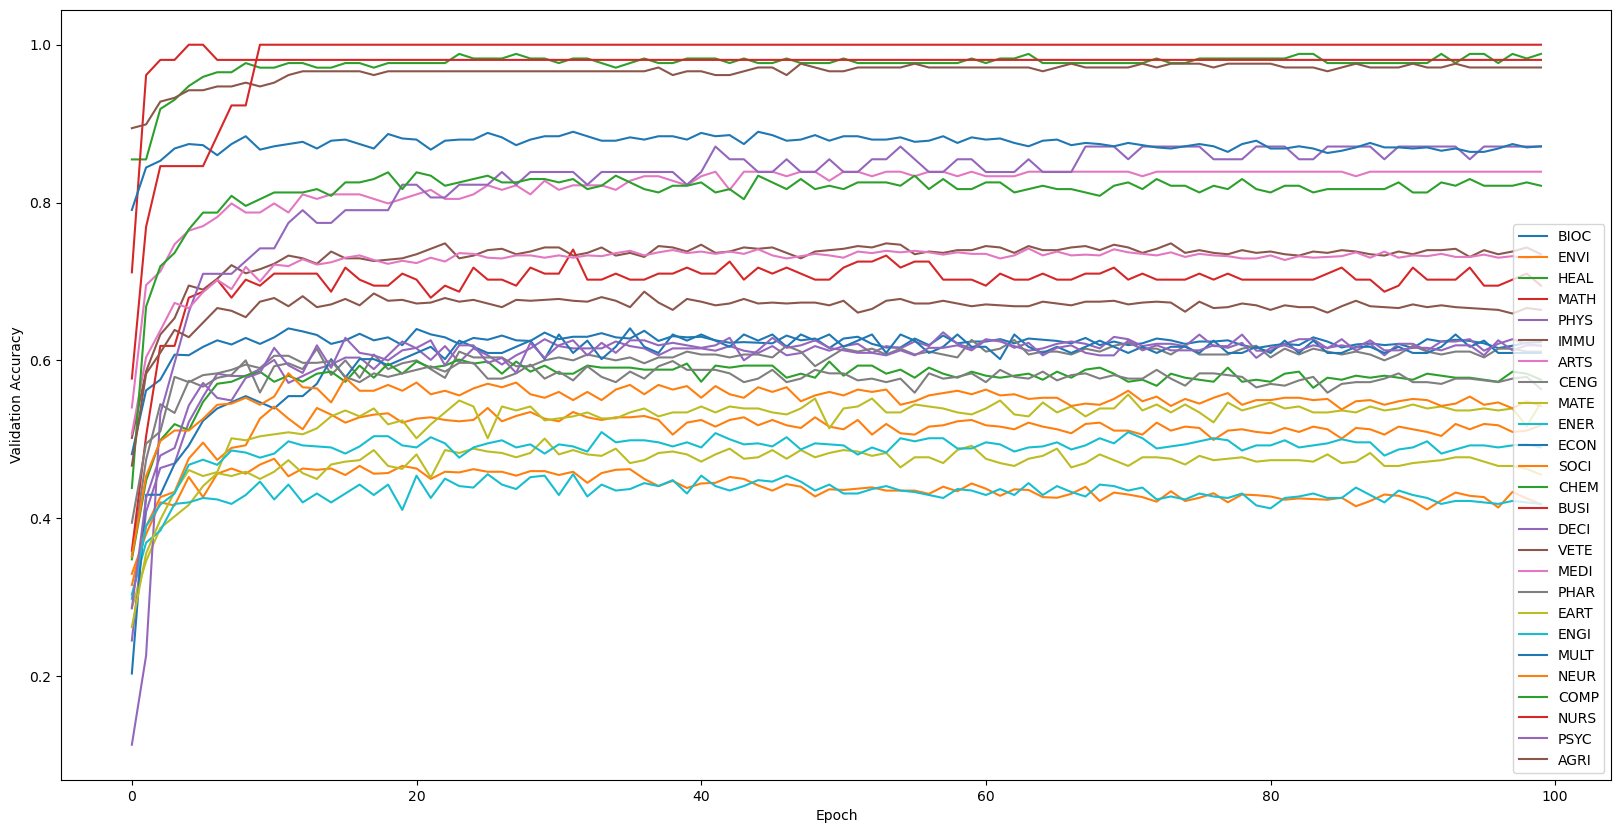

In [101]:
plt.figure(figsize=(20, 10))
# Train with given embeddings
for subj in unique_subject_areas:
    print(f"\nLearning for subject: {subj}")
    df = get_data(subj)
    print(f"Number of documents: {len(df)}")
    model, embedding, history = train_data_embedding(df, subj, e)
    val_accuracy = history.history['val_accuracy']
    plt.plot(val_accuracy, label=subj)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


Learning for subject: BIOC
Number of documents: 5293
Number of unique journals: 74
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_26 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 1s 5ms/step - loss: 2.9013 - accuracy: 0.3726 - val_loss: 2.1199 - val_accuracy: 0.4917
Epoch 2/100
125/125 [==============================] - 0s 4ms/step - loss: 1.7319 - accuracy: 0.5571 - val_loss: 1.6984 - val_accuracy: 0.5725
Epoch 3/100
125/125 [===========================

114/114 [==============================] - 1s 11ms/step - loss: 1.9538 - accuracy: 0.4574 - val_loss: 2.1607 - val_accuracy: 0.3995
Epoch 4/100
114/114 [==============================] - 1s 9ms/step - loss: 1.7424 - accuracy: 0.5154 - val_loss: 2.0676 - val_accuracy: 0.4160
Epoch 5/100
114/114 [==============================] - 1s 10ms/step - loss: 1.5953 - accuracy: 0.5442 - val_loss: 1.9998 - val_accuracy: 0.4283
Epoch 6/100
114/114 [==============================] - 1s 9ms/step - loss: 1.4729 - accuracy: 0.5859 - val_loss: 1.9392 - val_accuracy: 0.4514
Epoch 7/100
114/114 [==============================] - 1s 10ms/step - loss: 1.3719 - accuracy: 0.6090 - val_loss: 1.9422 - val_accuracy: 0.4349
Epoch 8/100
114/114 [==============================] - 1s 9ms/step - loss: 1.2925 - accuracy: 0.6269 - val_loss: 1.9098 - val_accuracy: 0.4498
Epoch 9/100
114/114 [==============================] - 1s 5ms/step - loss: 1.2117 - accuracy: 0.6593 - val_loss: 1.9001 - val_accuracy: 0.4555
Epoch 10

Epoch 60/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2450 - accuracy: 0.9687 - val_loss: 2.2654 - val_accuracy: 0.4292
Epoch 61/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2375 - accuracy: 0.9665 - val_loss: 2.2859 - val_accuracy: 0.4259
Epoch 62/100
114/114 [==============================] - 1s 7ms/step - loss: 0.2296 - accuracy: 0.9692 - val_loss: 2.2731 - val_accuracy: 0.4325
Epoch 63/100
114/114 [==============================] - 1s 8ms/step - loss: 0.2237 - accuracy: 0.9739 - val_loss: 2.3022 - val_accuracy: 0.4209
Epoch 64/100
114/114 [==============================] - 1s 10ms/step - loss: 0.2209 - accuracy: 0.9714 - val_loss: 2.3075 - val_accuracy: 0.4275
Epoch 65/100
114/114 [==============================] - 1s 9ms/step - loss: 0.2185 - accuracy: 0.9750 - val_loss: 2.3170 - val_accuracy: 0.4283
Epoch 66/100
114/114 [==============================] - 1s 6ms/step - loss: 0.2102 - accuracy: 0.9772 - val_loss: 2.3155 - val_accurac

Epoch 69/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0478 - val_accuracy: 0.9826
Epoch 70/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0472 - val_accuracy: 0.9826
Epoch 71/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9826
Epoch 72/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9826
Epoch 73/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 0.9826
Epoch 74/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 0.9826
Epoch 75/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9826
Epoch

5/5 [==============================] - 0s 12ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9808
Epoch 80/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9808
Epoch 81/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9808
Epoch 82/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9808
Epoch 83/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9808
Epoch 84/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9808
Epoch 85/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9808
Epoch 86/100
5/5 [========

Epoch 89/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 1.6018 - val_accuracy: 0.6064
Epoch 90/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0486 - accuracy: 1.0000 - val_loss: 1.5915 - val_accuracy: 0.6093
Epoch 91/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 1.6049 - val_accuracy: 0.6093
Epoch 92/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 1.6027 - val_accuracy: 0.6122
Epoch 93/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0435 - accuracy: 1.0000 - val_loss: 1.6138 - val_accuracy: 0.6006
Epoch 94/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 1.6207 - val_accuracy: 0.6122
Epoch 95/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 1.6235 - val_accuracy: 0.6122
Ep

55/55 [==============================] - 0s 6ms/step - loss: 0.0920 - accuracy: 0.9971 - val_loss: 0.9631 - val_accuracy: 0.7448
Epoch 42/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0881 - accuracy: 0.9971 - val_loss: 0.9410 - val_accuracy: 0.7362
Epoch 43/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.9988 - val_loss: 0.9715 - val_accuracy: 0.7379
Epoch 44/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0797 - accuracy: 0.9994 - val_loss: 0.9672 - val_accuracy: 0.7379
Epoch 45/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0768 - accuracy: 0.9983 - val_loss: 0.9573 - val_accuracy: 0.7483
Epoch 46/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0728 - accuracy: 0.9988 - val_loss: 0.9761 - val_accuracy: 0.7379
Epoch 47/100
55/55 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9988 - val_loss: 0.9567 - val_accuracy: 0.7293
Epoch 48/100
55/55 

17/17 [==============================] - 0s 9ms/step - loss: 0.0565 - accuracy: 1.0000 - val_loss: 0.4805 - val_accuracy: 0.8103
Epoch 51/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0556 - accuracy: 1.0000 - val_loss: 0.4778 - val_accuracy: 0.8103
Epoch 52/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.4770 - val_accuracy: 0.8046
Epoch 53/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 0.4809 - val_accuracy: 0.8046
Epoch 54/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0505 - accuracy: 1.0000 - val_loss: 0.4786 - val_accuracy: 0.8046
Epoch 55/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0490 - accuracy: 1.0000 - val_loss: 0.4809 - val_accuracy: 0.7989
Epoch 56/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0482 - accuracy: 1.0000 - val_loss: 0.4777 - val_accuracy: 0.8046
Epoch 57/100
1

Epoch 2/100
26/26 [==============================] - 0s 10ms/step - loss: 2.2466 - accuracy: 0.4042 - val_loss: 1.9910 - val_accuracy: 0.4481
Epoch 3/100
26/26 [==============================] - 0s 10ms/step - loss: 1.8475 - accuracy: 0.5068 - val_loss: 1.8033 - val_accuracy: 0.4667
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 1.5946 - accuracy: 0.5723 - val_loss: 1.6428 - val_accuracy: 0.4926
Epoch 5/100
26/26 [==============================] - 0s 10ms/step - loss: 1.4191 - accuracy: 0.6230 - val_loss: 1.5348 - val_accuracy: 0.5259
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 1.2919 - accuracy: 0.6551 - val_loss: 1.4776 - val_accuracy: 0.5593
Epoch 7/100
26/26 [==============================] - 0s 11ms/step - loss: 1.1808 - accuracy: 0.6984 - val_loss: 1.4483 - val_accuracy: 0.5481
Epoch 8/100
26/26 [==============================] - 0s 11ms/step - loss: 1.0944 - accuracy: 0.7318 - val_loss: 1.3793 - val_accuracy: 0.5778
Epoch 

52/52 [==============================] - 0s 4ms/step - loss: 1.1210 - accuracy: 0.7027 - val_loss: 1.8649 - val_accuracy: 0.4534
Epoch 12/100
52/52 [==============================] - 0s 4ms/step - loss: 1.0530 - accuracy: 0.7179 - val_loss: 1.8174 - val_accuracy: 0.4808
Epoch 13/100
52/52 [==============================] - 0s 4ms/step - loss: 1.0085 - accuracy: 0.7442 - val_loss: 1.8217 - val_accuracy: 0.4808
Epoch 14/100
52/52 [==============================] - 0s 4ms/step - loss: 0.9598 - accuracy: 0.7479 - val_loss: 1.8431 - val_accuracy: 0.4625
Epoch 15/100
52/52 [==============================] - 0s 4ms/step - loss: 0.9223 - accuracy: 0.7619 - val_loss: 1.8283 - val_accuracy: 0.4826
Epoch 16/100
52/52 [==============================] - 0s 4ms/step - loss: 0.8807 - accuracy: 0.7723 - val_loss: 1.7870 - val_accuracy: 0.4680
Epoch 17/100
52/52 [==============================] - 0s 5ms/step - loss: 0.8442 - accuracy: 0.7918 - val_loss: 1.7753 - val_accuracy: 0.4735
Epoch 18/100
52/52 

50/50 [==============================] - 1s 10ms/step - loss: 0.7884 - accuracy: 0.7828 - val_loss: 1.7238 - val_accuracy: 0.4633
Epoch 21/100
50/50 [==============================] - 0s 10ms/step - loss: 0.7644 - accuracy: 0.7985 - val_loss: 1.7376 - val_accuracy: 0.4557
Epoch 22/100
50/50 [==============================] - 0s 9ms/step - loss: 0.7345 - accuracy: 0.8073 - val_loss: 1.7415 - val_accuracy: 0.4482
Epoch 23/100
50/50 [==============================] - 1s 10ms/step - loss: 0.7267 - accuracy: 0.8010 - val_loss: 1.7681 - val_accuracy: 0.4520
Epoch 24/100
50/50 [==============================] - 1s 11ms/step - loss: 0.7004 - accuracy: 0.8180 - val_loss: 1.7626 - val_accuracy: 0.4463
Epoch 25/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6820 - accuracy: 0.8148 - val_loss: 1.8040 - val_accuracy: 0.4369
Epoch 26/100
50/50 [==============================] - 0s 10ms/step - loss: 0.6671 - accuracy: 0.8249 - val_loss: 1.7947 - val_accuracy: 0.4444
Epoch 27/100


Epoch 29/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3809 - accuracy: 0.9450 - val_loss: 1.1026 - val_accuracy: 0.6562
Epoch 30/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3677 - accuracy: 0.9529 - val_loss: 1.0862 - val_accuracy: 0.6484
Epoch 31/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3600 - accuracy: 0.9581 - val_loss: 1.0948 - val_accuracy: 0.6484
Epoch 32/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3480 - accuracy: 0.9476 - val_loss: 1.0856 - val_accuracy: 0.6250
Epoch 33/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3383 - accuracy: 0.9555 - val_loss: 1.1078 - val_accuracy: 0.6484
Epoch 34/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3211 - accuracy: 0.9634 - val_loss: 1.0922 - val_accuracy: 0.6484
Epoch 35/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3113 - accuracy: 0.9686 - val_loss: 1.0972 - val_accuracy: 0.6562

56/56 [==============================] - 0s 9ms/step - loss: 0.2610 - accuracy: 0.9752 - val_loss: 1.7106 - val_accuracy: 0.5278
Epoch 39/100
56/56 [==============================] - 1s 9ms/step - loss: 0.2504 - accuracy: 0.9752 - val_loss: 1.7211 - val_accuracy: 0.5245
Epoch 40/100
56/56 [==============================] - 0s 8ms/step - loss: 0.2424 - accuracy: 0.9758 - val_loss: 1.7124 - val_accuracy: 0.5126
Epoch 41/100
56/56 [==============================] - 0s 7ms/step - loss: 0.2409 - accuracy: 0.9730 - val_loss: 1.7171 - val_accuracy: 0.5346
Epoch 42/100
56/56 [==============================] - 0s 9ms/step - loss: 0.2321 - accuracy: 0.9781 - val_loss: 1.7320 - val_accuracy: 0.5177
Epoch 43/100
56/56 [==============================] - 1s 9ms/step - loss: 0.2218 - accuracy: 0.9803 - val_loss: 1.7254 - val_accuracy: 0.5295
Epoch 44/100
56/56 [==============================] - 1s 9ms/step - loss: 0.2123 - accuracy: 0.9826 - val_loss: 1.7564 - val_accuracy: 0.5194
Epoch 45/100
56/56 

Epoch 96/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 2.0670 - val_accuracy: 0.5008
Epoch 97/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0513 - accuracy: 1.0000 - val_loss: 2.0834 - val_accuracy: 0.5093
Epoch 98/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0506 - accuracy: 1.0000 - val_loss: 2.0959 - val_accuracy: 0.5093
Epoch 99/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0488 - accuracy: 1.0000 - val_loss: 2.0899 - val_accuracy: 0.5093
Epoch 100/100
56/56 [==============================] - 0s 4ms/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 2.0947 - val_accuracy: 0.5126

Learning for subject: CHEM
Number of documents: 1564
Number of unique journals: 34
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 768)]             

Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
13/13 [==============================] - 1s 24ms/step - loss: 3.9778 - accuracy: 0.1170 - val_loss: 2.0677 - val_accuracy: 0.2672
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 1.7063 - accuracy: 0.3893 - val_loss: 1.4470 - val_accuracy: 0.5115
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 1.4286 - accuracy: 0.5216 - val_loss: 1.3246 - val_accuracy: 0.5573
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 1.2370 - accuracy: 0.6005 - val_loss: 1.2003 - val_accuracy: 0.6031
Epoch 5/100
13/13 [==============================] - 0s 13ms/step - loss: 1.1115 - accuracy: 0.6463 - val_loss: 1.1263 - val_accuracy: 0.6412
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 1.0238 - accuracy: 0.6718 - val_loss: 1.0789 - val_accuracy: 0.6107
Epoch 7/100

6/6 [==============================] - 0s 16ms/step - loss: 0.7181 - accuracy: 0.7869 - val_loss: 0.8109 - val_accuracy: 0.7258
Epoch 10/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6692 - accuracy: 0.7814 - val_loss: 0.7737 - val_accuracy: 0.7258
Epoch 11/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6305 - accuracy: 0.8033 - val_loss: 0.7484 - val_accuracy: 0.7581
Epoch 12/100
6/6 [==============================] - 0s 18ms/step - loss: 0.5919 - accuracy: 0.8470 - val_loss: 0.7252 - val_accuracy: 0.7742
Epoch 13/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5639 - accuracy: 0.8470 - val_loss: 0.7083 - val_accuracy: 0.7419
Epoch 14/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5337 - accuracy: 0.8470 - val_loss: 0.6814 - val_accuracy: 0.7581
Epoch 15/100
6/6 [==============================] - 0s 17ms/step - loss: 0.5083 - accuracy: 0.8634 - val_loss: 0.6683 - val_accuracy: 0.7903
Epoch 16/100
6/6 [========

20/20 [==============================] - 0s 9ms/step - loss: 0.0933 - accuracy: 0.9808 - val_loss: 0.1390 - val_accuracy: 0.9615
Epoch 20/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0890 - accuracy: 0.9888 - val_loss: 0.1371 - val_accuracy: 0.9615
Epoch 21/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0824 - accuracy: 0.9872 - val_loss: 0.1297 - val_accuracy: 0.9567
Epoch 22/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0787 - accuracy: 0.9856 - val_loss: 0.1289 - val_accuracy: 0.9567
Epoch 23/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0764 - accuracy: 0.9904 - val_loss: 0.1290 - val_accuracy: 0.9663
Epoch 24/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0721 - accuracy: 0.9920 - val_loss: 0.1278 - val_accuracy: 0.9663
Epoch 25/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0674 - accuracy: 0.9920 - val_loss: 0.1237 - val_accuracy: 0.9663
Epoch 26/100
2

Epoch 28/100
97/97 [==============================] - 1s 8ms/step - loss: 0.0953 - accuracy: 0.9942 - val_loss: 0.9697 - val_accuracy: 0.7204
Epoch 29/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0897 - accuracy: 0.9945 - val_loss: 0.9688 - val_accuracy: 0.7262
Epoch 30/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0846 - accuracy: 0.9955 - val_loss: 0.9692 - val_accuracy: 0.7320
Epoch 31/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0800 - accuracy: 0.9958 - val_loss: 0.9568 - val_accuracy: 0.7330
Epoch 32/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0756 - accuracy: 0.9961 - val_loss: 0.9708 - val_accuracy: 0.7282
Epoch 33/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0714 - accuracy: 0.9974 - val_loss: 0.9733 - val_accuracy: 0.7388
Epoch 34/100
97/97 [==============================] - 1s 9ms/step - loss: 0.0663 - accuracy: 0.9981 - val_loss: 0.9802 - val_accuracy: 0.7262
Epoch 

Epoch 37/100
43/43 [==============================] - 0s 11ms/step - loss: 0.2499 - accuracy: 0.9725 - val_loss: 1.4120 - val_accuracy: 0.5947
Epoch 38/100
43/43 [==============================] - 0s 10ms/step - loss: 0.2395 - accuracy: 0.9748 - val_loss: 1.4244 - val_accuracy: 0.5857
Epoch 39/100
43/43 [==============================] - 0s 9ms/step - loss: 0.2363 - accuracy: 0.9755 - val_loss: 1.4202 - val_accuracy: 0.5857
Epoch 40/100
43/43 [==============================] - 0s 10ms/step - loss: 0.2297 - accuracy: 0.9748 - val_loss: 1.4413 - val_accuracy: 0.5746
Epoch 41/100
43/43 [==============================] - 0s 8ms/step - loss: 0.2222 - accuracy: 0.9725 - val_loss: 1.4240 - val_accuracy: 0.5924
Epoch 42/100
43/43 [==============================] - 0s 10ms/step - loss: 0.2132 - accuracy: 0.9792 - val_loss: 1.4402 - val_accuracy: 0.5791
Epoch 43/100
43/43 [==============================] - 0s 11ms/step - loss: 0.2100 - accuracy: 0.9814 - val_loss: 1.4473 - val_accuracy: 0.5924
E

38/38 [==============================] - 0s 5ms/step - loss: 0.2426 - accuracy: 0.9874 - val_loss: 1.5761 - val_accuracy: 0.5340
Epoch 47/100
38/38 [==============================] - 0s 9ms/step - loss: 0.2388 - accuracy: 0.9815 - val_loss: 1.5644 - val_accuracy: 0.5290
Epoch 48/100
38/38 [==============================] - 0s 8ms/step - loss: 0.2296 - accuracy: 0.9865 - val_loss: 1.5823 - val_accuracy: 0.5516
Epoch 49/100
38/38 [==============================] - 0s 5ms/step - loss: 0.2202 - accuracy: 0.9874 - val_loss: 1.5919 - val_accuracy: 0.5365
Epoch 50/100
38/38 [==============================] - 0s 5ms/step - loss: 0.2240 - accuracy: 0.9857 - val_loss: 1.5713 - val_accuracy: 0.5390
Epoch 51/100
38/38 [==============================] - 0s 7ms/step - loss: 0.2088 - accuracy: 0.9916 - val_loss: 1.5953 - val_accuracy: 0.5264
Epoch 52/100
38/38 [==============================] - 0s 11ms/step - loss: 0.2068 - accuracy: 0.9882 - val_loss: 1.5969 - val_accuracy: 0.5416
Epoch 53/100
38/38

 dense_45 (Dense)            (None, 378)               290682    
                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
73/73 [==============================] - 1s 5ms/step - loss: 3.5173 - accuracy: 0.1914 - val_loss: 2.6646 - val_accuracy: 0.3083
Epoch 2/100
73/73 [==============================] - 0s 5ms/step - loss: 2.2969 - accuracy: 0.3883 - val_loss: 2.2253 - val_accuracy: 0.4041
Epoch 3/100
73/73 [==============================] - 1s 9ms/step - loss: 1.8884 - accuracy: 0.4739 - val_loss: 2.0496 - val_accuracy: 0.4236
Epoch 4/100
73/73 [==============================] - 0s 5ms/step - loss: 1.6232 - accuracy: 0.5495 - val_loss: 1.8999 - val_accuracy: 0.4624
Epoch 5/100
73/73 [==============================] - 1s 9ms/step - loss: 1.4507 - accuracy: 0.5978 - val_loss: 1.8266 - val_accuracy: 0.

67/67 [==============================] - 1s 9ms/step - loss: 0.2719 - accuracy: 0.8938 - val_loss: 0.2867 - val_accuracy: 0.8854
Epoch 9/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2601 - accuracy: 0.9014 - val_loss: 0.2911 - val_accuracy: 0.8826
Epoch 10/100
67/67 [==============================] - 0s 5ms/step - loss: 0.2543 - accuracy: 0.9004 - val_loss: 0.2823 - val_accuracy: 0.8798
Epoch 11/100
67/67 [==============================] - 0s 4ms/step - loss: 0.2433 - accuracy: 0.9037 - val_loss: 0.2890 - val_accuracy: 0.8784
Epoch 12/100
67/67 [==============================] - 0s 5ms/step - loss: 0.2354 - accuracy: 0.9122 - val_loss: 0.3104 - val_accuracy: 0.8656
Epoch 13/100
67/67 [==============================] - 0s 7ms/step - loss: 0.2303 - accuracy: 0.9089 - val_loss: 0.2878 - val_accuracy: 0.8755
Epoch 14/100
67/67 [==============================] - 0s 4ms/step - loss: 0.2231 - accuracy: 0.9165 - val_loss: 0.2771 - val_accuracy: 0.8854
Epoch 15/100
67/67 [

Epoch 66/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0947 - accuracy: 0.9755 - val_loss: 0.3094 - val_accuracy: 0.8699
Epoch 67/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0947 - accuracy: 0.9707 - val_loss: 0.3070 - val_accuracy: 0.8727
Epoch 68/100
67/67 [==============================] - 1s 11ms/step - loss: 0.0928 - accuracy: 0.9755 - val_loss: 0.3246 - val_accuracy: 0.8769
Epoch 69/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0909 - accuracy: 0.9788 - val_loss: 0.3182 - val_accuracy: 0.8741
Epoch 70/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0885 - accuracy: 0.9811 - val_loss: 0.3075 - val_accuracy: 0.8784
Epoch 71/100
67/67 [==============================] - 1s 10ms/step - loss: 0.0878 - accuracy: 0.9788 - val_loss: 0.3131 - val_accuracy: 0.8727
Epoch 72/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0889 - accuracy: 0.9759 - val_loss: 0.3179 - val_accuracy: 0.8713
E

64/64 [==============================] - 0s 7ms/step - loss: 0.6887 - accuracy: 0.8172 - val_loss: 1.5018 - val_accuracy: 0.5600
Epoch 19/100
64/64 [==============================] - 1s 10ms/step - loss: 0.6668 - accuracy: 0.8192 - val_loss: 1.4788 - val_accuracy: 0.5644
Epoch 20/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6379 - accuracy: 0.8320 - val_loss: 1.4903 - val_accuracy: 0.5615
Epoch 21/100
64/64 [==============================] - 1s 10ms/step - loss: 0.6182 - accuracy: 0.8394 - val_loss: 1.5057 - val_accuracy: 0.5570
Epoch 22/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6002 - accuracy: 0.8404 - val_loss: 1.4729 - val_accuracy: 0.5748
Epoch 23/100
64/64 [==============================] - 1s 9ms/step - loss: 0.5736 - accuracy: 0.8503 - val_loss: 1.4907 - val_accuracy: 0.5704
Epoch 24/100
64/64 [==============================] - 1s 8ms/step - loss: 0.5575 - accuracy: 0.8617 - val_loss: 1.4794 - val_accuracy: 0.5733
Epoch 25/100
64/6

Epoch 76/100
64/64 [==============================] - 1s 9ms/step - loss: 0.1569 - accuracy: 0.9876 - val_loss: 1.7747 - val_accuracy: 0.5526
Epoch 77/100
64/64 [==============================] - 1s 9ms/step - loss: 0.1524 - accuracy: 0.9881 - val_loss: 1.8132 - val_accuracy: 0.5393
Epoch 78/100
64/64 [==============================] - 1s 8ms/step - loss: 0.1530 - accuracy: 0.9832 - val_loss: 1.8068 - val_accuracy: 0.5437
Epoch 79/100
64/64 [==============================] - 0s 5ms/step - loss: 0.1516 - accuracy: 0.9852 - val_loss: 1.7953 - val_accuracy: 0.5407
Epoch 80/100
64/64 [==============================] - 0s 5ms/step - loss: 0.1436 - accuracy: 0.9891 - val_loss: 1.8249 - val_accuracy: 0.5467
Epoch 81/100
64/64 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.9872 - val_loss: 1.8171 - val_accuracy: 0.5348
Epoch 82/100
64/64 [==============================] - 0s 4ms/step - loss: 0.1407 - accuracy: 0.9901 - val_loss: 1.8358 - val_accuracy: 0.5422
Epoch 

23/23 [==============================] - 0s 4ms/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.6391 - val_accuracy: 0.8128
Epoch 86/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.6398 - val_accuracy: 0.8213
Epoch 87/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.6325 - val_accuracy: 0.8170
Epoch 88/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.6361 - val_accuracy: 0.8170
Epoch 89/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.6334 - val_accuracy: 0.8128
Epoch 90/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.6410 - val_accuracy: 0.8043
Epoch 91/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.6395 - val_accuracy: 0.8170
Epoch 92/100
23/23 

3/3 [==============================] - 0s 15ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 96/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 97/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 98/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 99/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 100/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000

Learning for subject: PSYC
Number of documents: 1259
Number of unique journals: 26
Model: "model_50"
________________________________________________________________

                                                                 
Total params: 290682 (1.11 MB)
Trainable params: 290682 (1.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
82/82 [==============================] - 1s 13ms/step - loss: 2.9429 - accuracy: 0.3283 - val_loss: 2.0738 - val_accuracy: 0.4492
Epoch 2/100
82/82 [==============================] - 1s 10ms/step - loss: 1.6586 - accuracy: 0.5684 - val_loss: 1.6767 - val_accuracy: 0.5647
Epoch 3/100
82/82 [==============================] - 1s 11ms/step - loss: 1.2899 - accuracy: 0.6590 - val_loss: 1.4691 - val_accuracy: 0.5970
Epoch 4/100
82/82 [==============================] - 1s 11ms/step - loss: 1.0767 - accuracy: 0.7160 - val_loss: 1.3555 - val_accuracy: 0.6386
Epoch 5/100
82/82 [==============================] - 1s 10ms/step - loss: 0.9370 - accuracy: 0.7503 - val_loss: 1.3076 - val_accuracy: 0.6409
Epoch 6/100
82/82 [==============================] - 1s 

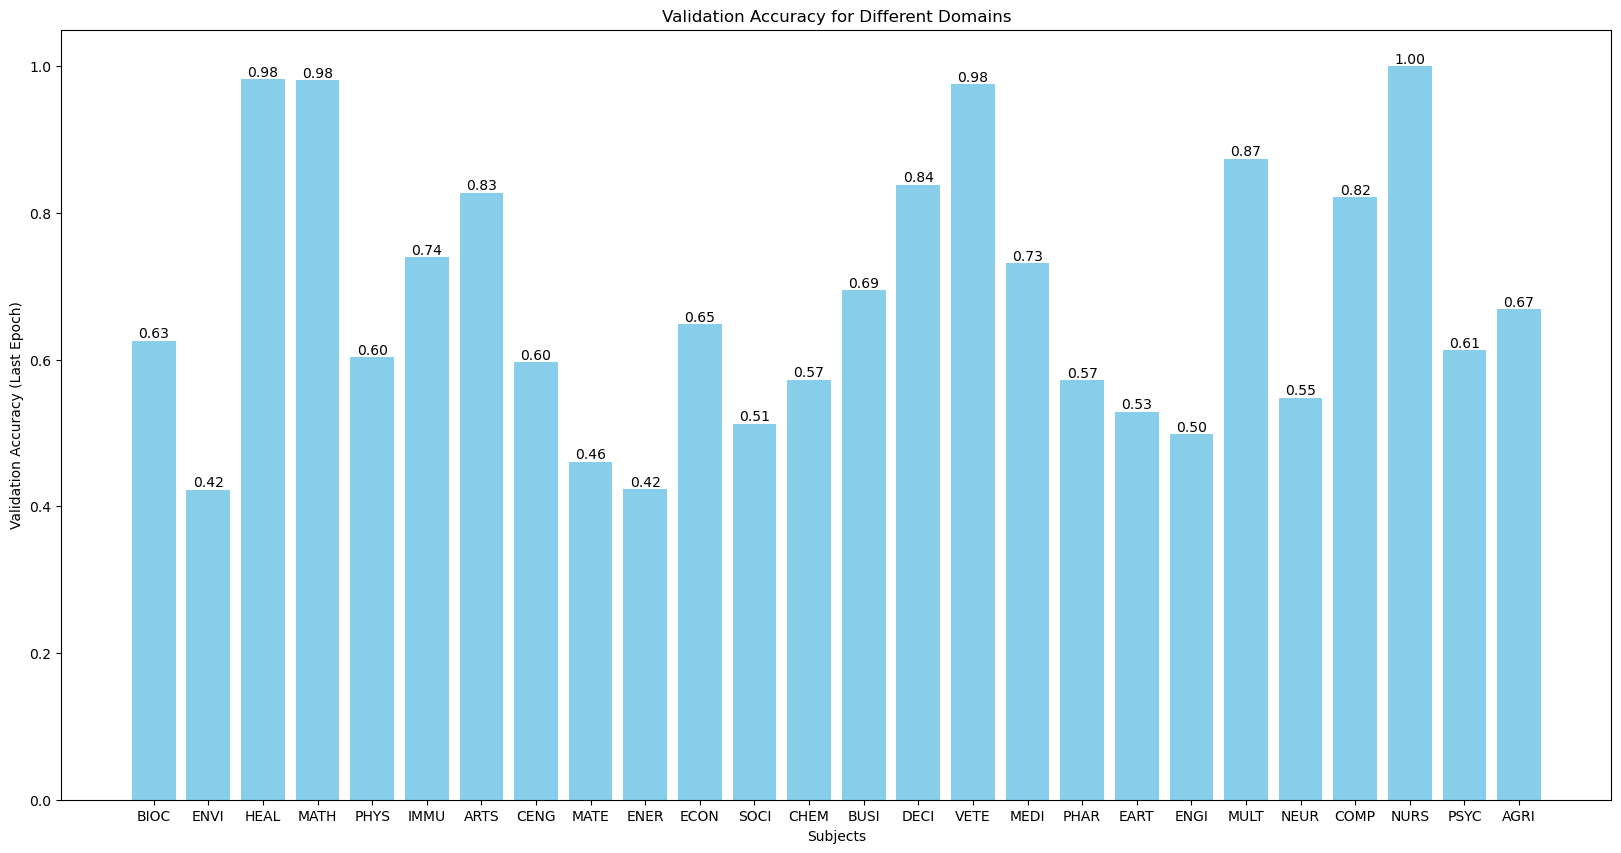

In [45]:
last_val_accuracy_values = []
for subj in unique_subject_areas:
    print(f"\nLearning for subject: {subj}")
    df = get_data(subj)
    print(f"Number of documents: {len(df)}")
    model, embedding, history = train_data_embedding(df, subj, e)
    val_accuracy = history.history['val_accuracy']
    last_val_accuracy = val_accuracy[-1]
    last_val_accuracy_values.append(last_val_accuracy)

plt.figure(figsize=(20, 10))
plt.bar(unique_subject_areas, last_val_accuracy_values, color='skyblue')

for i, v in enumerate(last_val_accuracy_values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Subjects')
plt.ylabel('Validation Accuracy (Last Epoch)')
plt.title('Validation Accuracy for Different Domains')

plt.show()

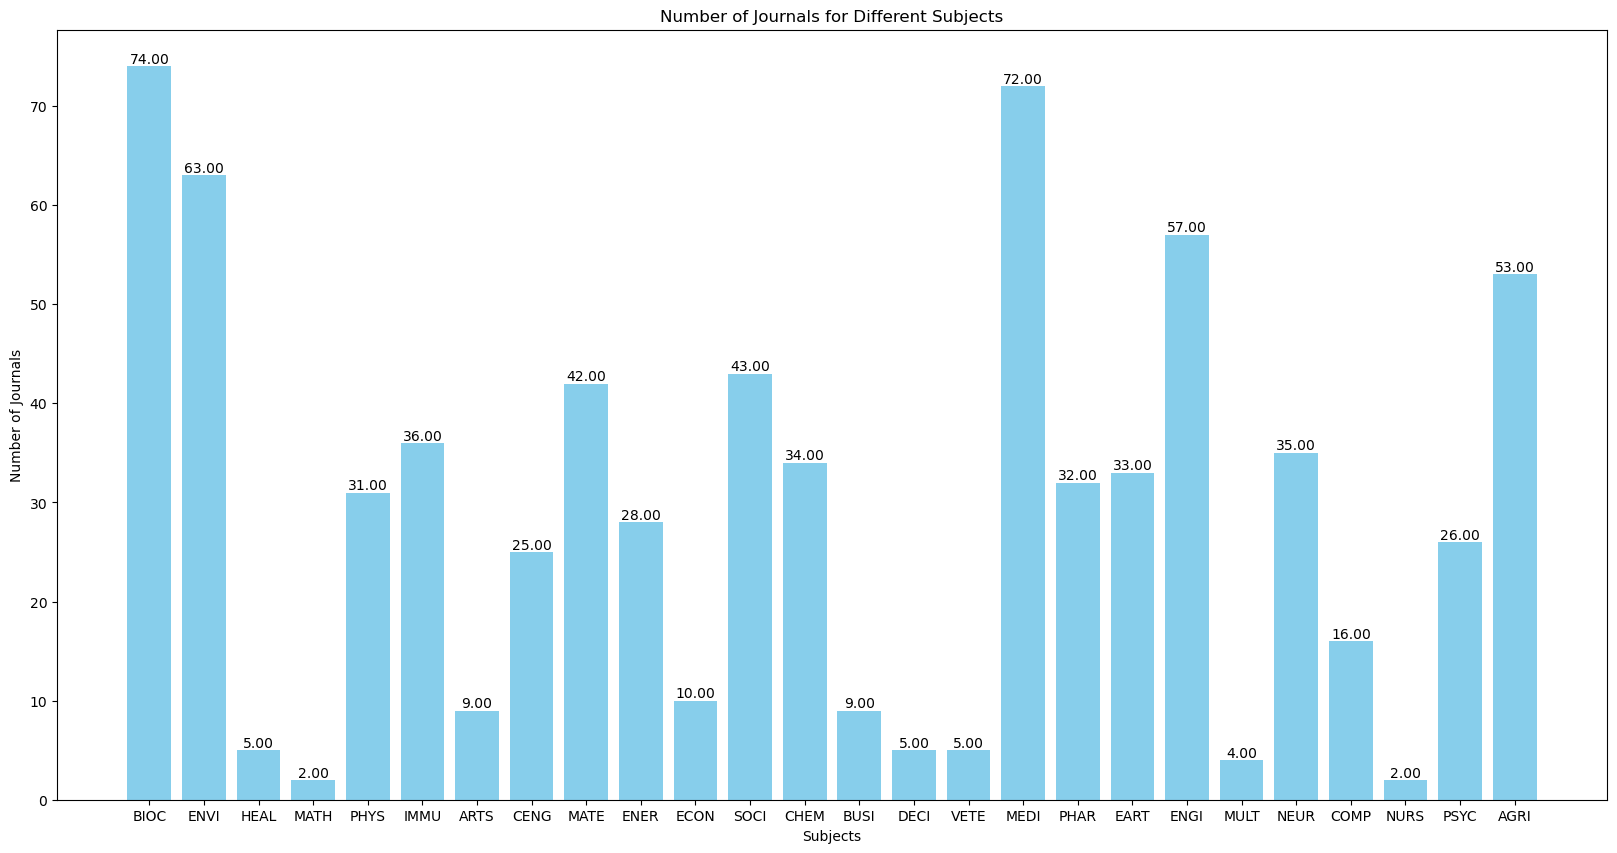

In [64]:
def get_journal_num(df):
    y = df.doi
    labels_as_int = [dois_list.index(l) for l in y]
    count_unique = len(set(labels_as_int))
    return count_unique

journal_num = []

for each in unique_subject_areas:
    df = get_data(each)
    journal_num.append(get_journal_num(df))

plt.figure(figsize=(20, 10))
plt.bar(unique_subject_areas, journal_num, color='skyblue')

for i, v in enumerate(journal_num):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)
    
plt.xlabel('Subjects')
plt.ylabel('Number of Journals')
plt.title('Number of Journals for Different Subjects')

plt.show()

# Subject area model (X:subjareas; Y:doi)

In [103]:
X = data.subjareas
y = data.doi

if len(X) == len(y):
    print("The lengths of X and y are equal.")
else:
    print("The lengths of X and y are not equal.")

The lengths of X and y are equal.


In [104]:
X=to_lower(X)
X = X.apply(lambda x: ' '.join(ast.literal_eval(x)))
X

0        engi medi soci
1        engi medi soci
2        engi medi soci
3        engi medi soci
4        engi medi soci
              ...      
35365         bioc medi
35366         bioc medi
35367         bioc medi
35368         bioc medi
35369         bioc medi
Name: subjareas, Length: 27023, dtype: object

In [105]:
vectorizer = CountVectorizer(min_df=10, max_df=0.995)
vectorize = vectorizer.fit_transform(X)

X = vectorize.toarray()
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [106]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([ 1,  1,  1, ..., 50, 50, 50])

In [107]:
one_hot_y = OneHotEncoder(sparse=False)
one_hot_y = one_hot_y.fit_transform(y.reshape(-1, 1))
one_hot_y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [108]:
train_X, test_X, train_y, test_y = train_test_split(X, one_hot_y, test_size=0.15)

In [109]:
model = Sequential()

model.add(Dense(units=len(le.classes_), input_dim=len(X[0]), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
180/180 [==============================] - 1s 5ms/step - loss: 5.6935 - accuracy: 0.2023 - val_loss: 5.4522 - val_accuracy: 0.3071
Epoch 2/50
180/180 [==============================] - 1s 5ms/step - loss: 5.2114 - accuracy: 0.3597 - val_loss: 4.9915 - val_accuracy: 0.3944
Epoch 3/50
180/180 [==============================] - 1s 4ms/step - loss: 4.7606 - accuracy: 0.4248 - val_loss: 4.5644 - val_accuracy: 0.4295
Epoch 4/50
180/180 [==============================] - 1s 3ms/step - loss: 4.3470 - accuracy: 0.4362 - val_loss: 4.1763 - val_accuracy: 0.4339
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 3.9773 - accuracy: 0.4439 - val_loss: 3.8336 - val_accuracy: 0.4504
Epoch 6/50
180/180 [==============================] - 1s 4ms/step - loss: 3.6531 - accuracy: 0.4597 - val_loss: 3.5329 - val_accuracy: 0.4613
Epoch 7/50
180/180 [==============================] - 1s 4ms/step - loss: 3.3705 - accuracy: 0.4705 - val_loss: 3.2702 - val_accuracy: 0.4726
Epoch 

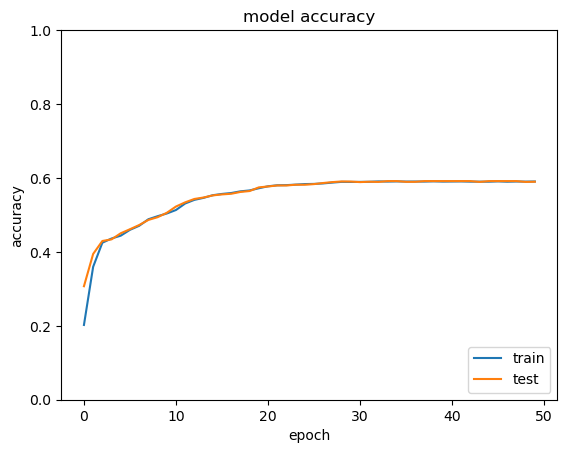

In [110]:
# visualise training history
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.ylim(0, 1)
plt.show()

Now use the test set to get prediction

In [111]:
prediction = model.predict(test_X)

127/127 [==============================] - 0s 1ms/step


Get the top 5 journals with most accuracy.

In [112]:
one = prediction[0]
indexs = one.argsort()

for each in np.flip(indexs[-5:]):
    print(le.inverse_transform([each]), one[each])

['softx'] 0.789142
['jss'] 0.051370535
['csbj'] 0.038081117
['envsoft'] 0.02796211
['jbi'] 0.019468771


Plot it in graph to put into perspective

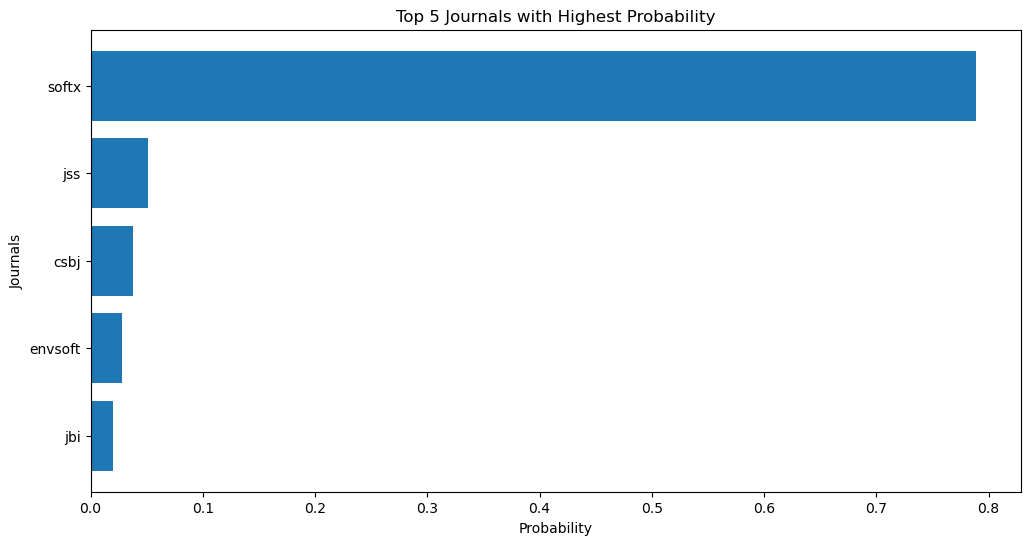

In [113]:
top_journals = np.flip(indexs[-5:])
top_probabilities = one[top_journals]

journal_labels = le.inverse_transform(top_journals)

plt.figure(figsize=(12, 6))
plt.barh(journal_labels, top_probabilities)
plt.xlabel('Probability')
plt.ylabel('Journals')
plt.title('Top 5 Journals with Highest Probability')
plt.gca().invert_yaxis()  
plt.show()

Save the final accuracy as a pickle file

In [114]:
unique_subject_areas_lower = [i.lower() for i in unique_subject_areas]
print(unique_subject_areas_lower)

['bioc', 'envi', 'heal', 'math', 'phys', 'immu', 'arts', 'ceng', 'mate', 'ener', 'econ', 'soci', 'chem', 'busi', 'deci', 'vete', 'medi', 'phar', 'eart', 'engi', 'mult', 'neur', 'comp', 'nurs', 'psyc', 'agri']


In [115]:
subjs_model_acc = {}
for i in range(0, len(unique_subject_areas_lower)):
    subjs_model_acc[unique_subject_areas_lower[i]] = last_val_accuracy_values[i]

subj_acc = history.history['val_accuracy'][-1]
print(subj_acc)

0.5897878408432007


In [116]:
print(subjs_model_acc)

{'bioc': 0.6261329054832458, 'envi': 0.42257001996040344, 'heal': 0.9825581312179565, 'math': 0.9807692170143127, 'phys': 0.6034985184669495, 'immu': 0.7396551966667175, 'arts': 0.8275862336158752, 'ceng': 0.5962963104248047, 'mate': 0.46069470047950745, 'ener': 0.4237288236618042, 'econ': 0.6484375, 'soci': 0.5126475691795349, 'chem': 0.572890043258667, 'busi': 0.694656491279602, 'deci': 0.8387096524238586, 'vete': 0.9759615659713745, 'medi': 0.7320388555526733, 'phar': 0.5723830461502075, 'eart': 0.5289672613143921, 'engi': 0.4987046718597412, 'mult': 0.8741160035133362, 'neur': 0.5481481552124023, 'comp': 0.8212766051292419, 'nurs': 1.0, 'psyc': 0.6126984357833862, 'agri': 0.6685912013053894}


In [98]:
len(subjs_model_acc)

26

In [99]:
# filename = f'models/model_accuracy.pkl'
# with open(filename, "wb") as file:
#     pickle.dump((subj_acc, subjs_model_acc), file)